# MLC: Multi-Label Classification with DistilBert

This notebook fine-tunes a pre-trained variant of the BERT model, called 
DistilBERT in order to classify domain specific feedback texts to 1, none, or multiple
 of the following labels that describe a certain topic of a certain feedback text.


* `delivery`: 
  * relating to the delivery service itself
  * questions about the status of the package
* `return`:
  * concerning the return service
  * often about the return label sticker that has to be included when returning an item
  * support requests on returning an item
* `product`:
  * describing the condition of the product
  * has to mention the type of product as well, e.g. shoe, dress, etc.
* `monetary`:
  * financial issues
  * discount requests
  * pending transactions

# Goal

A portion of the original dataset does not belong to any of these labels. After close inspection many of the samples clearly are simply missing appropriate labelling. By making use of the data that has been already labelled, a Machine Learning model is trained in a supervised manner in order to predict the labels missing on the dataset of the same domain.

# Approach & Notes

* Instead of the Multi-Class approach in which only a single label is allowed to be predicted, Multe-Label is chosen since the text samples can exhibit multiple categories
* Since it is more important to identify one of the four categories mentioned above as the main theme of the text, the prediction of multiple labels is less important and treated more as a supplement to the main labels. 
* Naturally, there will be more samples of text containing only a single category than multiple ones, making the dataset somewhat unbalanced. Regardless, as long as the main four categories can be idetified with good enough confidence (see confusion matrix), it is presentable for the prototype
* Gathering more data for samples that have more than 1 label would make the data more balanced and increase the performance for these cases

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers==3.0.2 >> /dev/null
!pip install scikit-plot >> /dev/null

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn.functional as F
import scikitplot as skplt
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')
import unicodedata
import time
import re
import gc

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/Colab/data/ma_data/'
DATA_WITH_LABELS = PROJECT_PATH + 'feedback_onehot_with_labels.csv'
DATA_NO_LABELS = PROJECT_PATH + 'feedback_onehot_no_labels.csv'

MODEL_PATH = PROJECT_PATH + 'feedback_mlc_model_v08',
RESULTS_PATH = PROJECT_PATH + 'mlc_v8_2'
DATA_MLC_PREDICTIONS = PROJECT_PATH + 'feedback_mlc_predictions_v08.csv'

In [ ]:
def render_label_distribution(df, labels):
  num_columns = len(labels)
  fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 5, 7))
  counter = 0
  for idx in range(0, len(labels)):

    if (counter == num_columns):
      fig, ax = plt.subplots(1, num_columns, figsize=(num_columns * 5, 7))
      counter = 0
      
    graph = sns.countplot(x=labels[idx], 
                  data=df[[labels[idx]]], 
                  ax=ax[counter])
    graph.set(xlabel=None)
    graph.set(ylabel=None)
    graph.set(title=labels[idx])
        
    counter += 1

Data length:  31807
Count of 1 per label: 
 delivery            9408
feedback_return     8672
product             8347
monetary           10437
dtype: int64 

Count of 0 per label: 
 delivery           22399
feedback_return    23135
product            23460
monetary           21370
dtype: int64


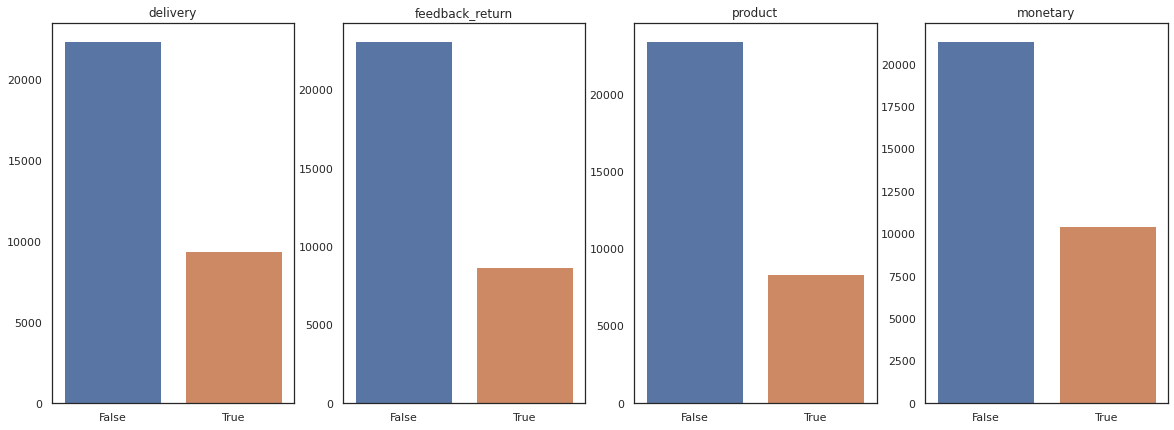

In [ ]:
df = pd.read_csv(DATA_WITH_LABELS)
cols = ["delivery", "feedback_return", "product", "monetary"]
df = df.sample(frac=1, random_state=42)
render_label_distribution(df, cols)
print("Data length: ", len(df))
print("Count of 1 per label: \n", df[cols].sum(), '\n') 
print("Count of 0 per label: \n", df[cols].eq(0).sum())

In [ ]:
df.head()

id  ... one_hot_labels
2540    2918  ...   [1, 0, 0, 0]
8904   10527  ...   [1, 0, 0, 0]
1588    1794  ...   [1, 0, 1, 0]
19548  23754  ...   [0, 0, 0, 1]
23783  31848  ...   [0, 0, 0, 1]

[5 rows x 8 columns]

In [ ]:
label_counts = df["one_hot_labels"].astype(str).value_counts()
label_counts

[0, 0, 0, 1]    7593
[1, 0, 0, 0]    7256
[0, 1, 0, 0]    6214
[0, 0, 1, 0]    6078
[0, 1, 0, 1]    1014
[1, 0, 0, 1]     790
[0, 0, 1, 1]     764
[0, 1, 1, 0]     703
[1, 0, 1, 0]     547
[1, 1, 0, 0]     488
[1, 0, 1, 1]     107
[1, 1, 0, 1]     105
[1, 1, 1, 0]      84
[0, 1, 1, 1]      33
[1, 1, 1, 1]      31
Name: one_hot_labels, dtype: int64

# Data Preparation

* `label2idx` is used since the cross-validator below can not handle string labels. Converting them to indices instead, which will be reverted back to strings during before passing it to the dataloaders

In [ ]:
unique_label = list(set(df["one_hot_labels"].astype(str).tolist()))
unique_label.append('[0, 0, 0, 0]')
unique_label.sort()
label2idx = dict(zip(unique_label, range(len(unique_label))))
idx2label = dict(zip(range(len(unique_label)), unique_label))
label2idx

{'[0, 0, 0, 0]': 0,
 '[0, 0, 0, 1]': 1,
 '[0, 0, 1, 0]': 2,
 '[0, 0, 1, 1]': 3,
 '[0, 1, 0, 0]': 4,
 '[0, 1, 0, 1]': 5,
 '[0, 1, 1, 0]': 6,
 '[0, 1, 1, 1]': 7,
 '[1, 0, 0, 0]': 8,
 '[1, 0, 0, 1]': 9,
 '[1, 0, 1, 0]': 10,
 '[1, 0, 1, 1]': 11,
 '[1, 1, 0, 0]': 12,
 '[1, 1, 0, 1]': 13,
 '[1, 1, 1, 0]': 14,
 '[1, 1, 1, 1]': 15}

In [ ]:
def preprocess(texts):
    res = []
    for text in texts:
        # Lowercase
        text = text.lower()

        # Remove words containing at least 3 'x'
        text = re.sub(r'(\b\w*[x,X]{3,}\w*\b)', '', text)
        text = " ".join(text.split())
        res.append(text)
    
    return res

In [ ]:
class DatasetPair(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self, idx):
        return self.datalist[idx]

In [ ]:
def create_data_loaders_from_indices(X, y, train_indices, valid_indices, batch_size):

    print(f"<<<< length train: {len(train_indices)}")
    print(f"<<<< length validation: {len(valid_indices)}")

    # Convert back from idx to list of labels
    y_labels = [np.fromstring(idx2label[idx][1:-1], sep=",") for idx in y]

    # Instead of TensorDataset try encode during model training
    X_train = np.array(X)[train_indices].astype(str)
    y_train = np.array(y_labels)[train_indices].astype(int)
    train_data = DatasetPair(X_train, y_train)

    X_valid = np.array(X)[valid_indices].astype(str)
    y_valid = np.array(y_labels)[valid_indices].astype(int)
    validation_data = DatasetPair(X_valid, y_valid)

    # DataLoaders instead of conventional for loops to avoid memory issue during training
    train_sampler = RandomSampler(train_data) # Randomize train data because good practice
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    validation_sampler = SequentialSampler(validation_data) # Validation does not need to be randomized
    valid_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, valid_dataloader

In [ ]:
def transform_to_flat_booleans(y_true, y_pred, threshold):
    # Flatten
    true_labels = [item for sublist in y_true for item in sublist]
    pred_labels = [item for sublist in y_pred for item in sublist]

    # Convert to Booleans
    true_bools = [true == 1 for true in true_labels]
    pred_bools = [pred > threshold for pred in pred_labels]

    return true_bools, pred_bools

In [ ]:
# Micro-average will aggregate the contributions of all classes to compute the average metric, useful for class imbalance
def get_avg_metrics(y_true, y_pred, threshold):
    true_bools, pred_bools = transform_to_flat_booleans(y_true, y_pred, threshold)
    acc = accuracy_score(true_bools, pred_bools)
    f1 = f1_score(true_bools, pred_bools, average='micro')
    return acc, f1

In [ ]:
def get_multiclass_labels(class_names, threshold, label_batches):
    classes = []
    for batch in label_batches: 
        for values in batch:
            classes_tmp = []
            for idx, val in enumerate(values):
                if val > threshold:
                    if len(classes_tmp) > 0:
                        classes_tmp.append(" + ")    
                    class_name = class_names[int(idx)]      
                    classes_tmp.append(class_names[int(idx)])

            classes.append("".join(classes_tmp))
    return classes

In [ ]:
def train_model(model, tokenizer, train_loader, valid_loader, epochs, patience, batch_size, seq_len, lr, unique_labels):
    num_labels = len(unique_labels)
    class_names = dict(zip(range(num_labels), unique_labels))
    print(f"class names: {class_names}")
    
    num_training_steps = int(len(train_loader) * epochs)
    validate_every = len(train_loader) // 5
    print(f"\n===== Total Training Steps: {num_training_steps} = ({len(train_loader)} batches x {epochs} epochs) =====")
    
    # Setup training components
    warmup_modifier = 0.1
    pred_threshold = 0.5 # default is 0.5. Experimenting with 0.62, found by optimizing for f1 score below though this needs more investigation
    optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=warmup_modifier, 
                                                num_training_steps=num_training_steps)
    
    # Since each label is binary and do not affect each other
    criterion = BCEWithLogitsLoss() 
    
    # Set to training mode
    model.train()

    # Initialize complete tracking variables
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0

    for epoch in trange(epochs, desc="Epoch"):
        print(f"\n===== Epoch: {epoch + 1} =====")

        # Initialize individual tracking variables
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []

        for batch in train_loader:
            text_batch, labels_batch = batch

            # Skip the last batch of which size is not equal to batch_size
            if labels_batch.size(0) != batch_size:
                break

            steps += 1

            # Reset gradient (default: gradients accumulate)
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % validate_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            text_encoded = tokenizer.batch_encode_plus(text_batch, 
                                        max_length=seq_len, 
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_tensors="pt").to(device)
            
            # Feedforward pass for MLC: Passing labels property here would turn it into Multi-Class instead
            outputs = model(**text_encoded) 
            logits = outputs[0]

            # Loss function has to be manually added for MLC as opposed to Multi-Class
            loss = criterion(logits.view(-1, num_labels), 
                             labels_batch.type_as(logits).view(-1, num_labels)) #convert labels to float for calculation

            # y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_pred_tmp.append(torch.sigmoid(logits).to('cpu').detach().numpy())
            y_truth_tmp.append(labels_batch.to('cpu').numpy())

            # Back propagation
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Update weights and learning rate
            optimizer.step()
            scheduler.step()

            #################### Evaluation ####################
            if (steps % validate_every == 0) or ((steps % validate_every != 0) and (steps == len(train_loader))):

                # Evaluate Training
                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp, pred_threshold)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp / loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Reset metrics
                y_truth_tmp, y_pred_tmp = [], []

                # Evaluation mode
                model.eval()

                # We do not need to update gradients during validation
                with torch.no_grad():
                    for batch in valid_loader:
                        text_batch, labels_batch = batch

                        # Skip the last batch of which size is not equal to batch_size
                        if labels_batch.size(0) != batch_size:
                            break

                        text_encoded = tokenizer.batch_encode_plus(text_batch, 
                                        max_length=seq_len, 
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_tensors="pt").to(device)

                        outputs = model(**text_encoded) 
                        logits = outputs[0]    

                        loss = criterion(logits.view(-1, num_labels), 
                                         labels_batch.type_as(logits).view(-1, num_labels)) #convert labels to float for calculation

                        y_pred_tmp.append(torch.sigmoid(logits).to('cpu').numpy())
                        y_truth_tmp.append(labels_batch.to('cpu').numpy())

                        # Validation Loss
                        loss_tmp += loss.item()
                        loss_cnt += 1

                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp, pred_threshold)
                print(f"Epoch: {epoch + 1}/{epochs}, Loss: {(loss_tmp / loss_cnt):.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")

                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp / loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Prepare to train again for next epoch
                model.train()
                        
        #################### End of each epoch ####################

        # Show the last evaluation metrics and classification report
        print(f"\nEpoch: {epoch+1}, Loss: {loss_valid[-1]:.4f}, Acc: {acc_valid[-1]:.4f}, F1: {f1_valid[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.2e}\n")
        
        # Confusion Matrix
        true_classes = get_multiclass_labels(class_names, pred_threshold, y_truth_tmp)
        pred_classes = get_multiclass_labels(class_names, pred_threshold, y_pred_tmp)
        titles_options = [("Counts", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            _, ax = plt.subplots(figsize=(15, 15))
            disp = skplt.metrics.plot_confusion_matrix(true_classes, pred_classes, normalize=normalize, title=title, x_tick_rotation="vertical", ax=ax)
        plt.show()

        # Plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        torch.cuda.empty_cache()
        model.train()
        
    print(f"############## Cleaning up ###############")
    del optimizer
    del scheduler
    gc.collect()
    torch.cuda.empty_cache()

    return loss_valid[-1], acc, f1, model

In [ ]:
def train(model_path, num_labels, unique_labels, X, y, epochs, patience, batch_size, seq_len, lr):
    print("\n############### Start training ###############")
    start_time = time.perf_counter() 
    loss_folds, acc_folds, f1_folds = [], [], []
    n_splits = 5
    model_final = None

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for idx, (train_indices, valid_indices) in enumerate(kfold.split(X, y)):
        print(f"\n############### k-fold: {idx+1} ###############")

        # New model every fold
        model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
        tokenizer = DistilBertTokenizer.from_pretrained(model_path, do_lower_case=True)
        model.to(device)

        train_dataloader, valid_dataloader = create_data_loaders_from_indices(X, 
                                                                              y, 
                                                                              train_indices, 
                                                                              valid_indices, 
                                                                              batch_size)


        loss, acc, f1, model_trained = train_model(model,
                                              tokenizer,
                                              train_dataloader, 
                                              valid_dataloader, 
                                              epochs, 
                                              patience, 
                                              batch_size, 
                                              seq_len, 
                                              lr, 
                                              unique_labels)
        loss_folds.append(loss)
        acc_folds.append(acc)
        f1_folds.append(f1)

        # Save only the last model
        if idx == n_splits -1:
            model_final = model_trained

    end_time = time.perf_counter()
    duration = end_time - start_time
    print("Process Time (sec): {}".format(duration))
    print(f"acc: {acc:.4f}, f1: {f1:.4f}, duration: {duration / 1000}")

    return loss_folds, acc_folds, f1_folds, model_final

# Configure Model

In [ ]:
MODEL_PATH = 'distilbert-base-uncased' #@param {type:"string"}
NUM_LABELS = len(cols)
UNIQUE_LABELS = cols
EPOCHS = 3 #@param {type:"number"}
PATIENCE = 3 #@param {type:"number"}
BATCH_SIZE = 32 #@param {type:"number"}
SEQ_LEN = 256 #@param {type:"number"}
LR = 3e-5 #@param {type:"number"}

In [ ]:
texts_raw = df["feedback_text_en"].astype(str).tolist()
texts = preprocess(texts_raw)
label_values = df['one_hot_labels'].tolist()

labels = [label2idx[label] for label in label_values]
print(f"Train length: {len(labels)}")

Train length: 31807



############### Start training ###############

############### k-fold: 1 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<<<< length train: 25445
<<<< length validation: 6362


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

class names: {0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}

===== Total Training Steps: 2388 = (796 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.2751, Acc: 0.7173, F1: 0.8095
Epoch: 1/3, Loss: 0.2034, Acc: 0.7718, F1: 0.8604
Epoch: 1/3, Loss: 0.1915, Acc: 0.7707, F1: 0.8610
Epoch: 1/3, Loss: 0.1760, Acc: 0.7858, F1: 0.8761
Epoch: 1/3, Loss: 0.1685, Acc: 0.7902, F1: 0.8830

Epoch: 1, Loss: 0.1685, Acc: 0.7902, F1: 0.8830, LR: 1.48e-05



/usr/local/lib/python3.7/dist-packages/scikitplot/metrics.py:124: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


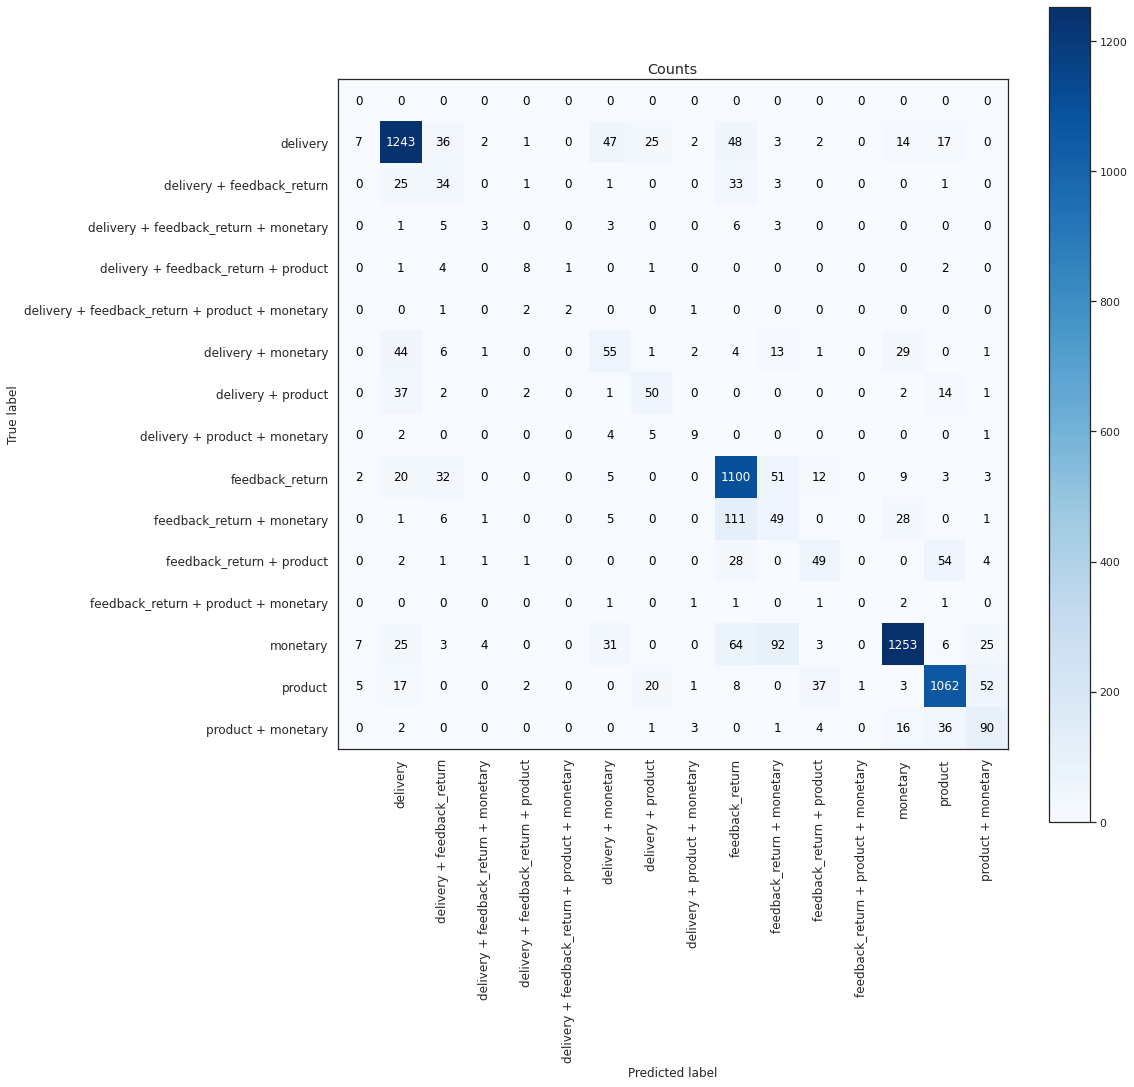

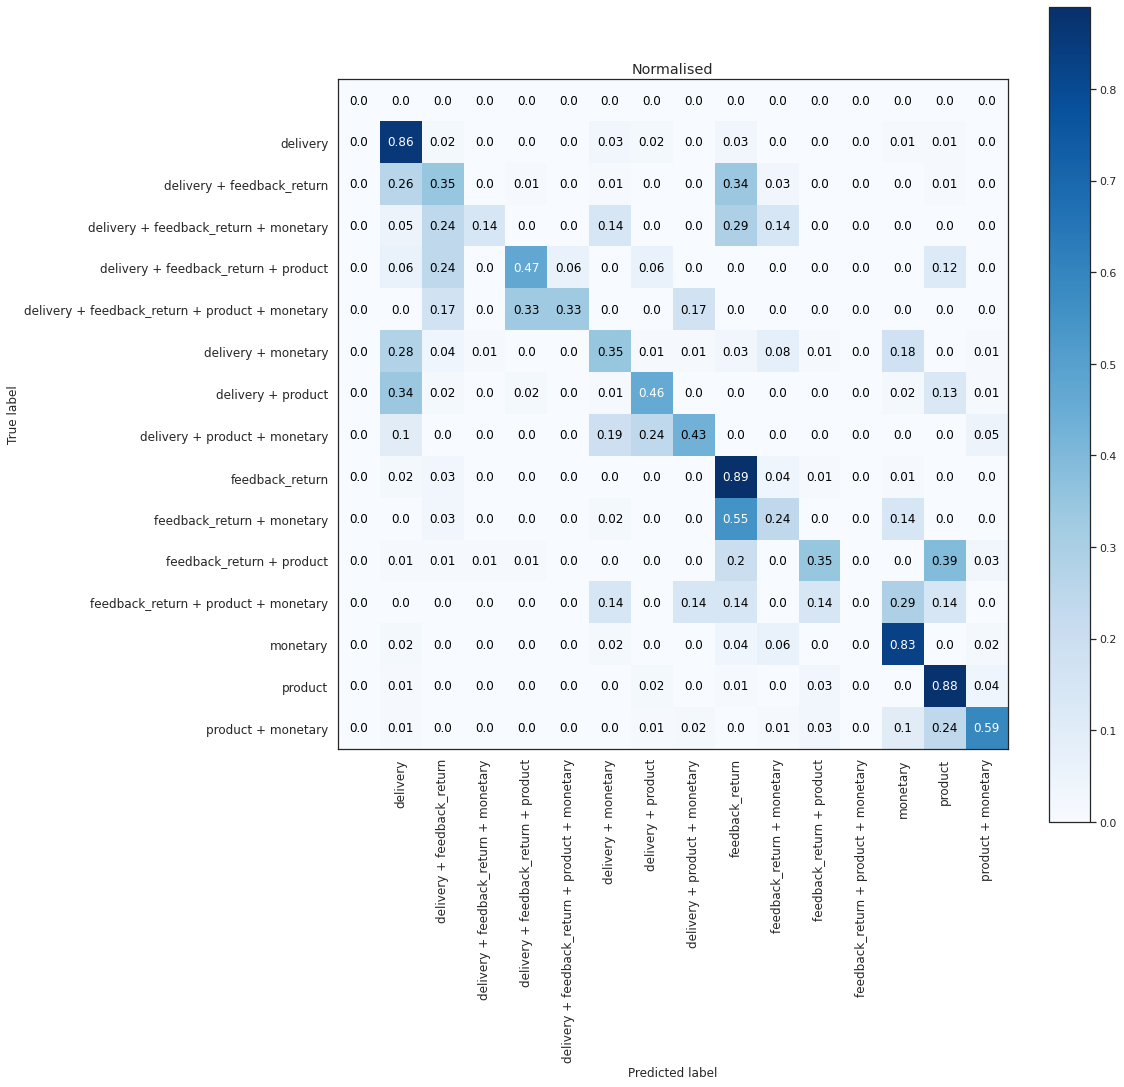

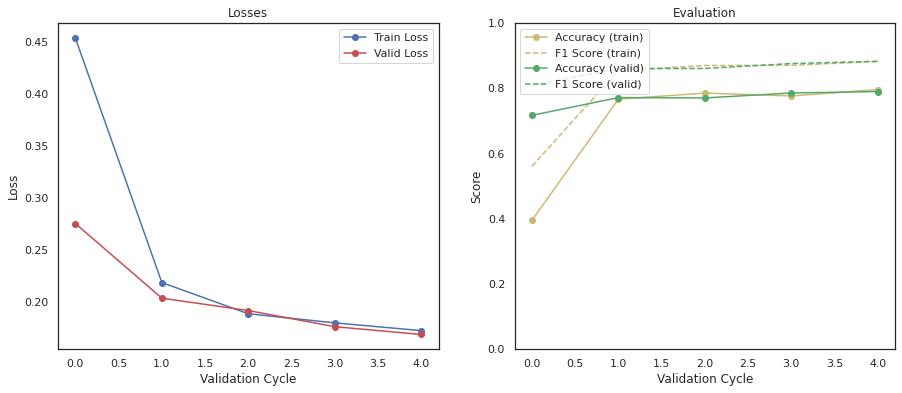

Epoch:  33%|███▎      | 1/3 [13:21<26:42, 801.13s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1673, Acc: 0.7931, F1: 0.8853
Epoch: 2/3, Loss: 0.1686, Acc: 0.7912, F1: 0.8832
Epoch: 2/3, Loss: 0.1669, Acc: 0.7877, F1: 0.8852
Epoch: 2/3, Loss: 0.1704, Acc: 0.7906, F1: 0.8839
Epoch: 2/3, Loss: 0.1640, Acc: 0.7953, F1: 0.8859
Epoch: 2/3, Loss: 0.1618, Acc: 0.7986, F1: 0.8872

Epoch: 2, Loss: 0.1618, Acc: 0.7986, F1: 0.8872, LR: 7.43e-06



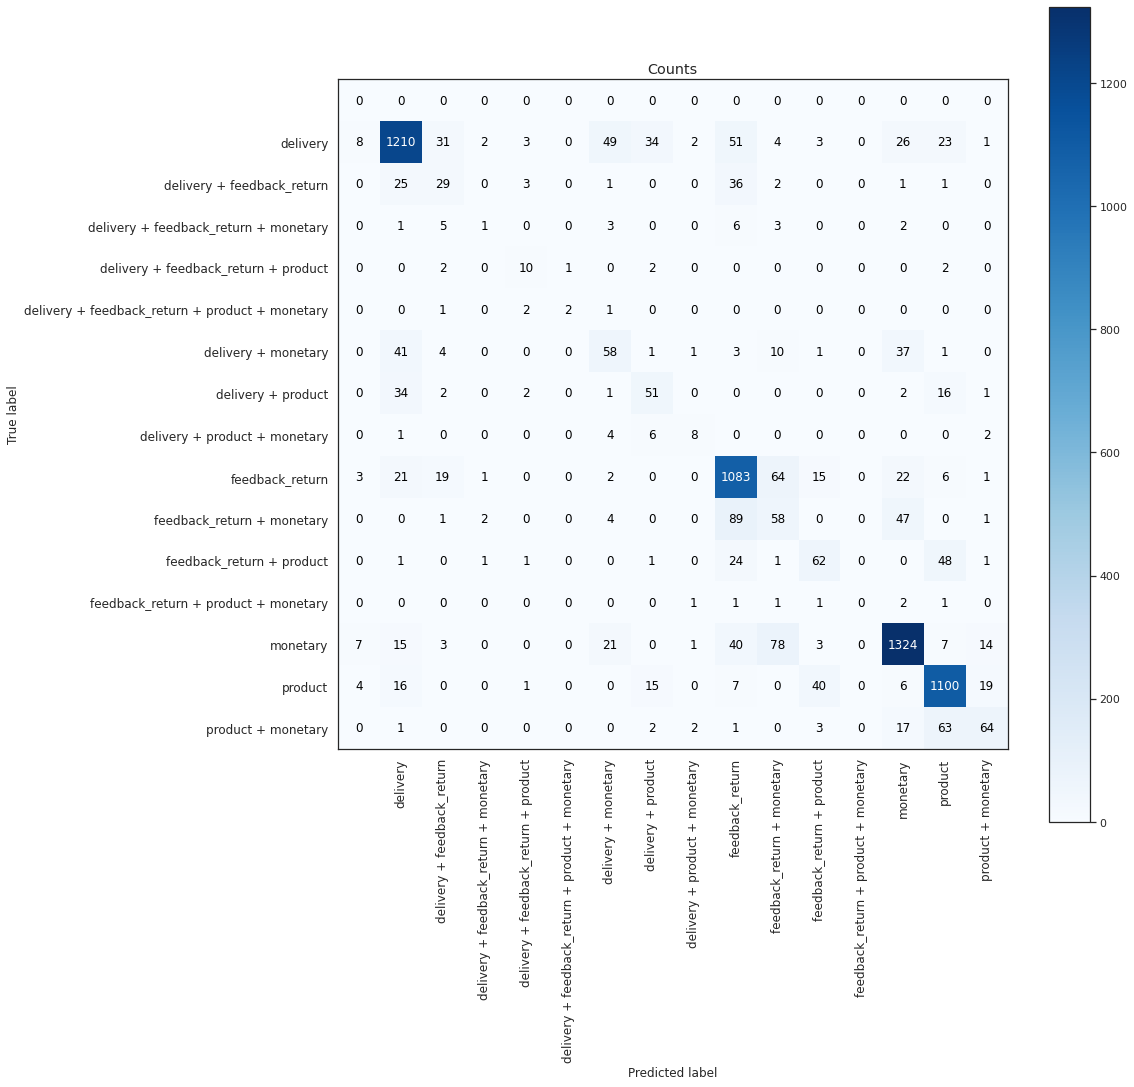

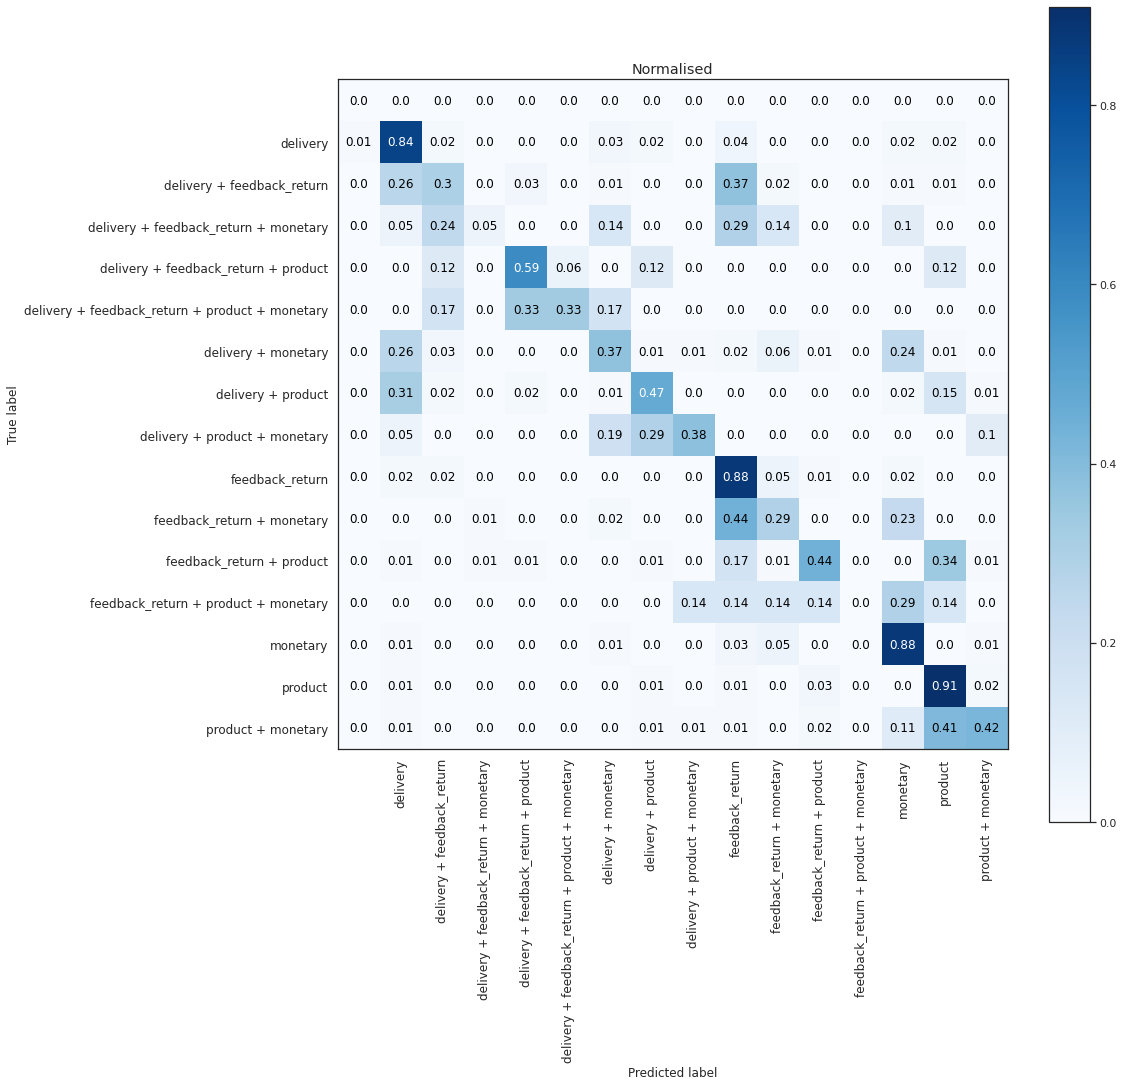

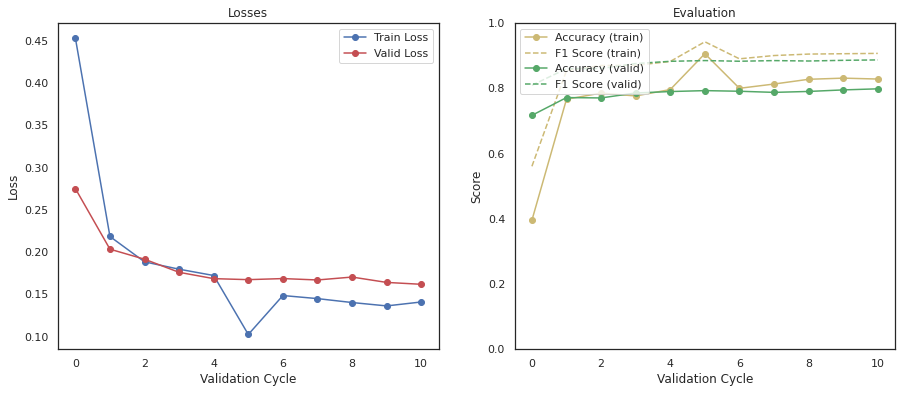

Epoch:  67%|██████▋   | 2/3 [27:47<13:40, 820.63s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1672, Acc: 0.7962, F1: 0.8860
Epoch: 3/3, Loss: 0.1664, Acc: 0.7958, F1: 0.8856
Epoch: 3/3, Loss: 0.1661, Acc: 0.7958, F1: 0.8869
Epoch: 3/3, Loss: 0.1666, Acc: 0.7970, F1: 0.8875
Epoch: 3/3, Loss: 0.1652, Acc: 0.7951, F1: 0.8872

Epoch: 3, Loss: 0.1652, Acc: 0.7951, F1: 0.8872, LR: 2.79e-08



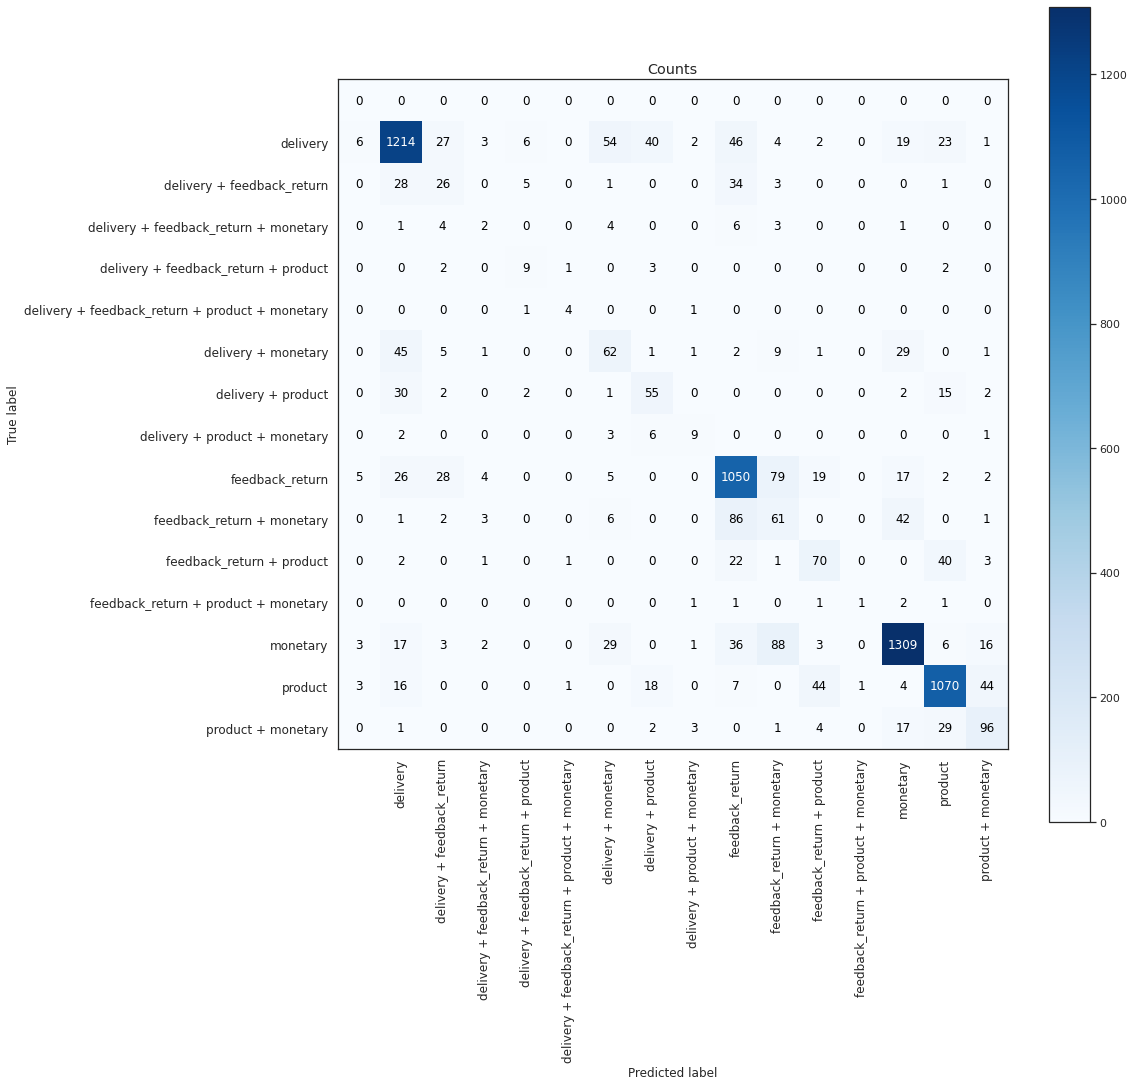

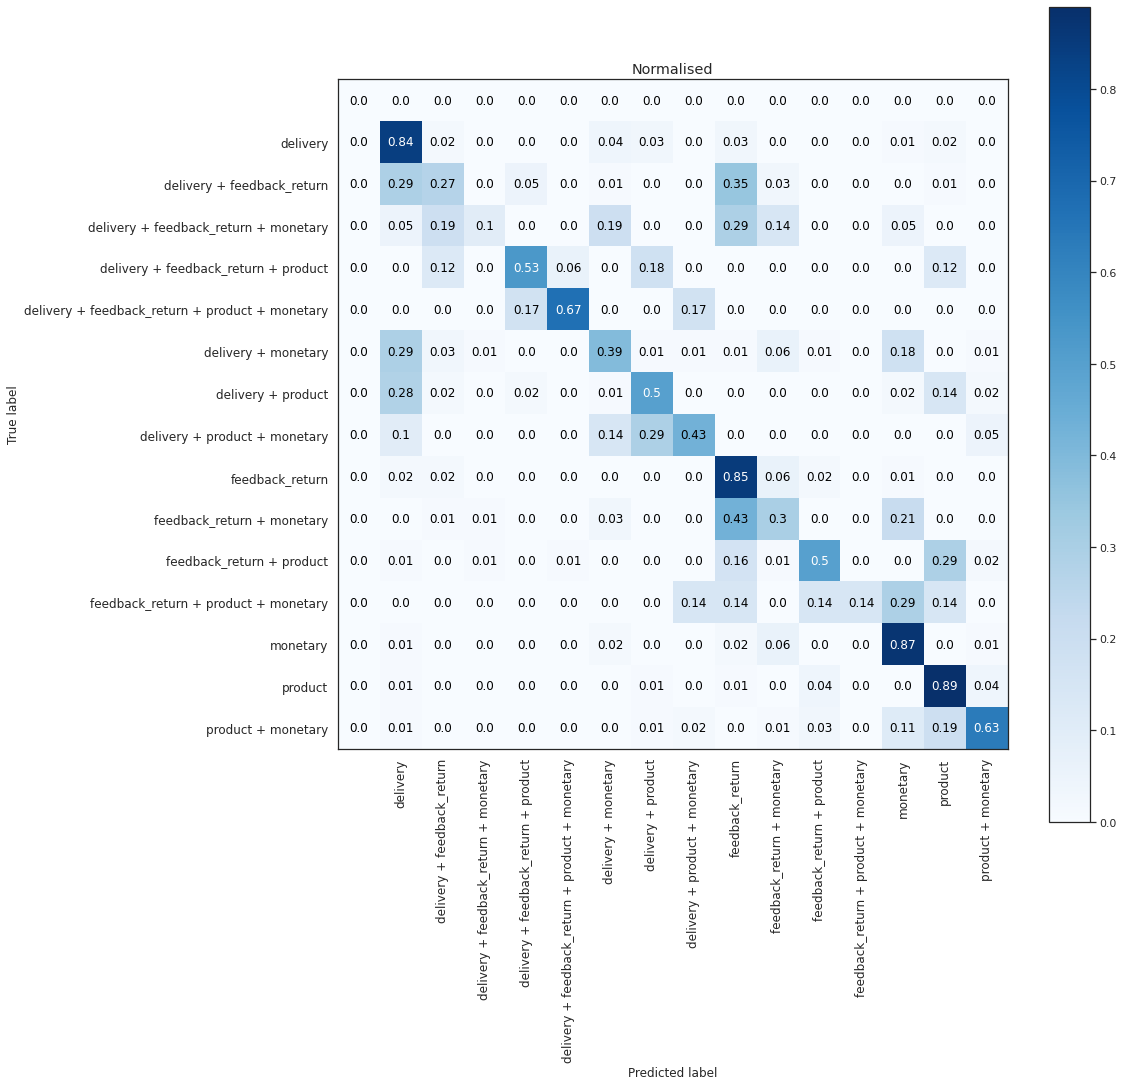

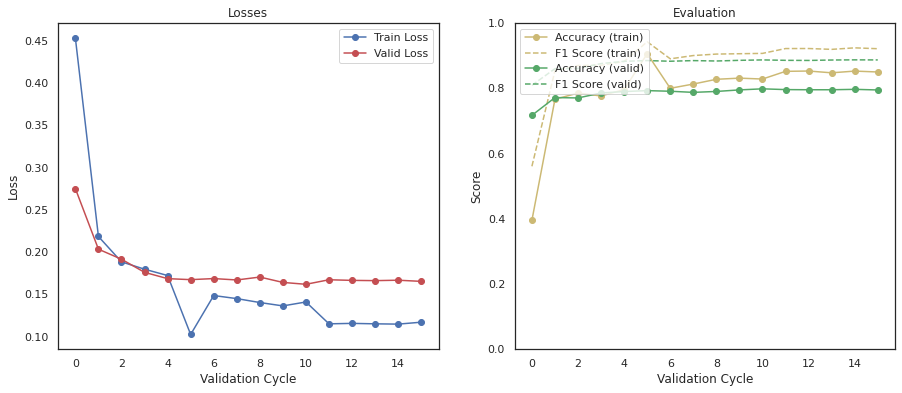

Epoch: 100%|██████████| 3/3 [41:24<00:00, 828.05s/it]


############## cleaning up ###############

############### k-fold: 2 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<<<< length train: 25445
<<<< length validation: 6362


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

class names: {0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}

===== Total Training Steps: 2388 = (796 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.2492, Acc: 0.7473, F1: 0.8325
Epoch: 1/3, Loss: 0.2061, Acc: 0.7663, F1: 0.8557
Epoch: 1/3, Loss: 0.1793, Acc: 0.7794, F1: 0.8778
Epoch: 1/3, Loss: 0.1740, Acc: 0.7839, F1: 0.8771
Epoch: 1/3, Loss: 0.1627, Acc: 0.7985, F1: 0.8857

Epoch: 1, Loss: 0.1627, Acc: 0.7985, F1: 0.8857, LR: 1.48e-05



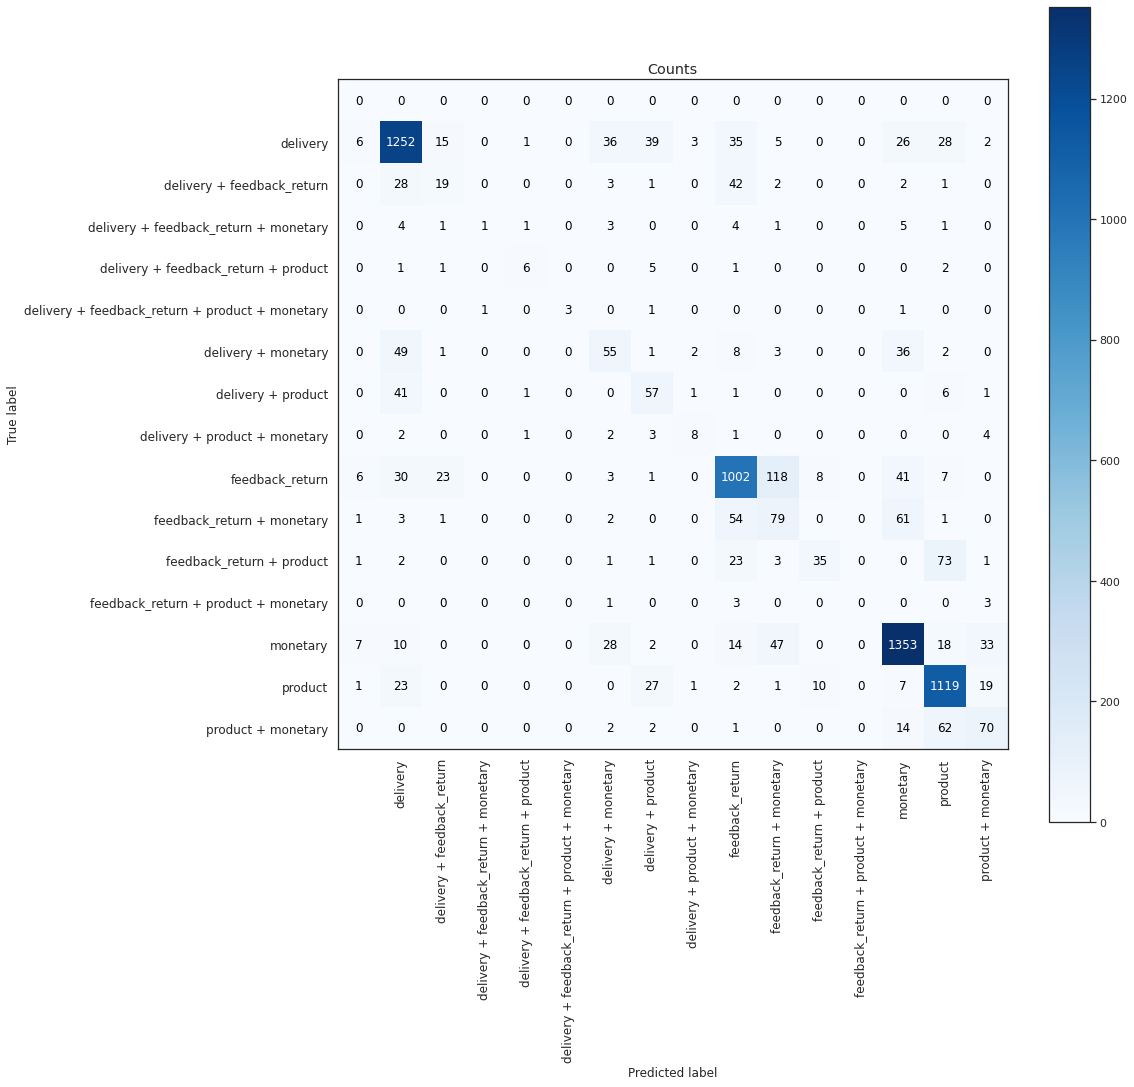

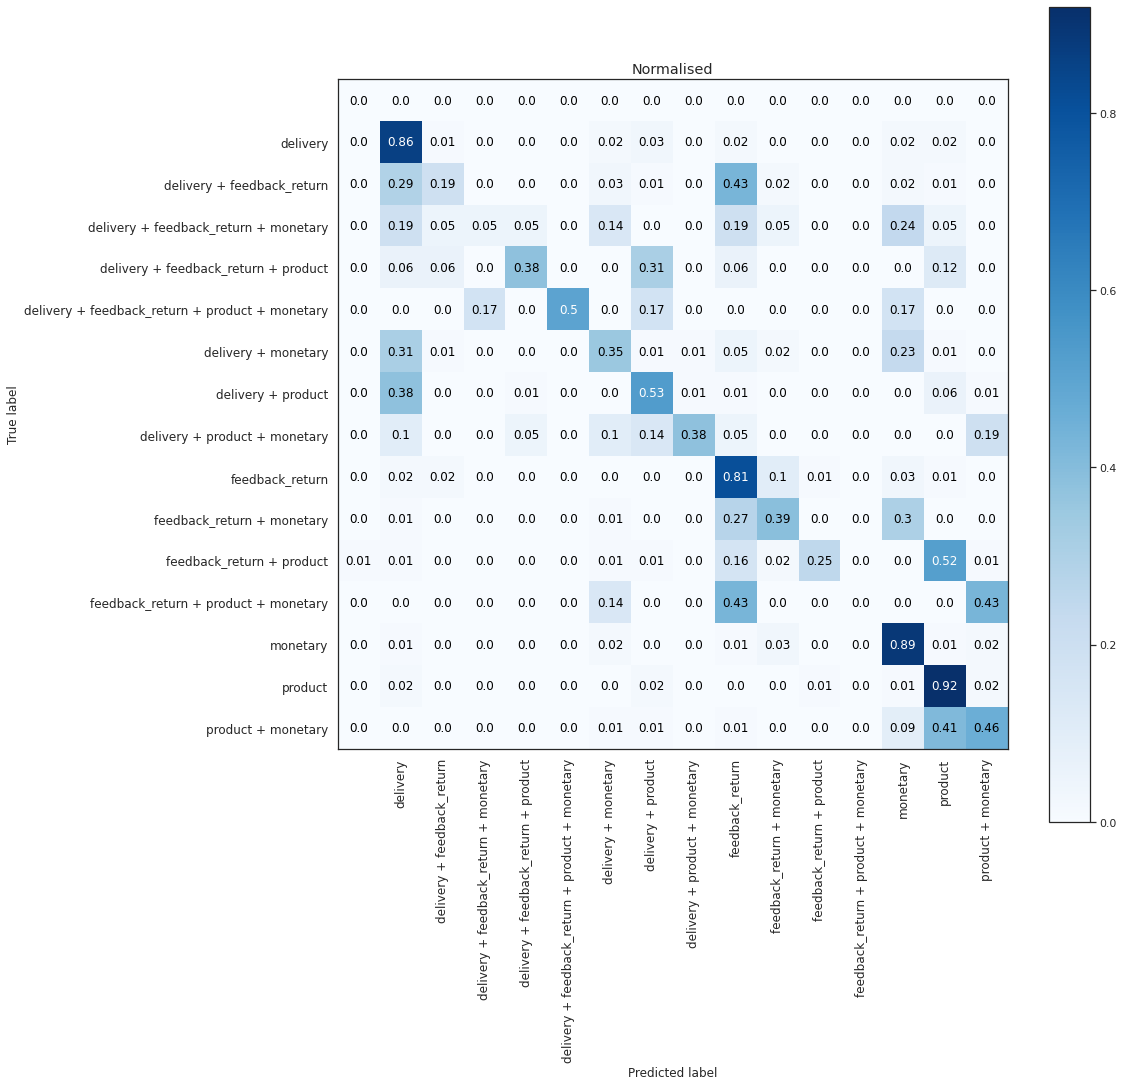

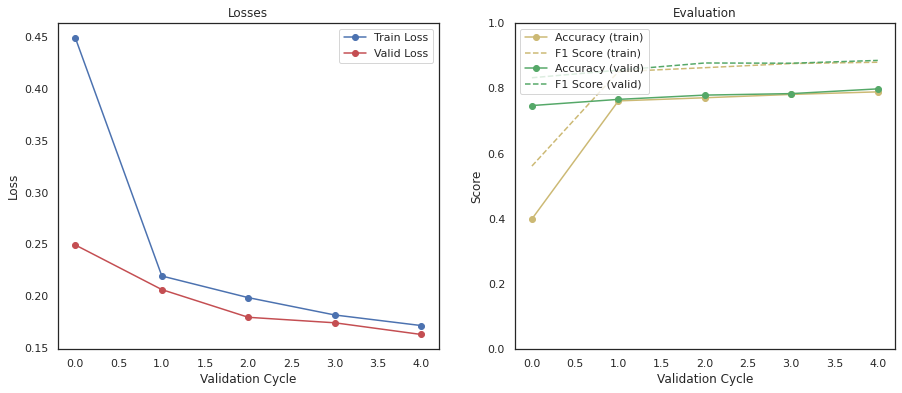

Epoch:  33%|███▎      | 1/3 [13:34<27:09, 814.76s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1625, Acc: 0.7983, F1: 0.8859
Epoch: 2/3, Loss: 0.1657, Acc: 0.7950, F1: 0.8856
Epoch: 2/3, Loss: 0.1618, Acc: 0.7980, F1: 0.8875
Epoch: 2/3, Loss: 0.1607, Acc: 0.7942, F1: 0.8855
Epoch: 2/3, Loss: 0.1613, Acc: 0.7997, F1: 0.8866
Epoch: 2/3, Loss: 0.1578, Acc: 0.8062, F1: 0.8921

Epoch: 2, Loss: 0.1578, Acc: 0.8062, F1: 0.8921, LR: 7.43e-06



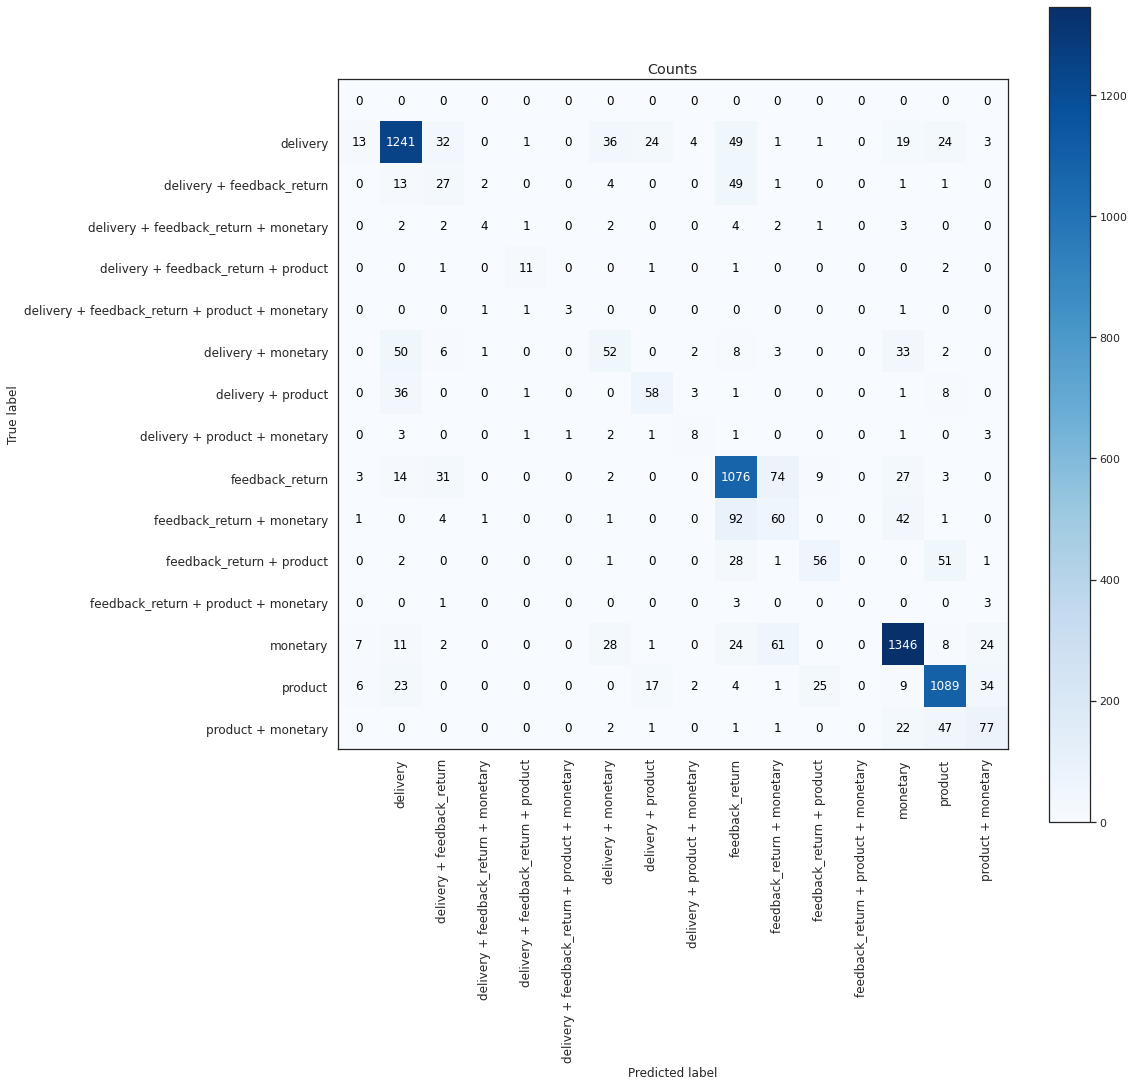

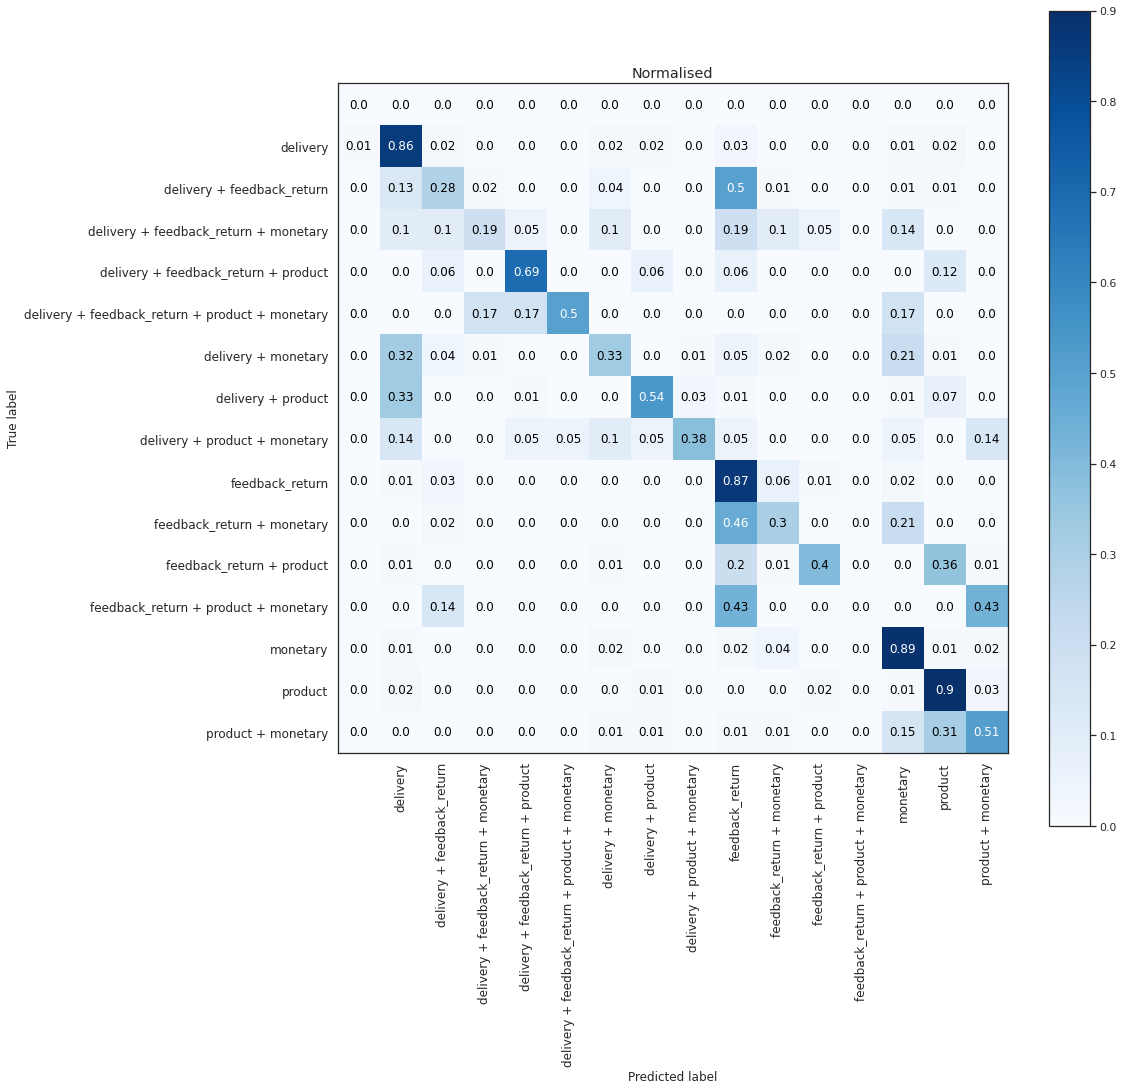

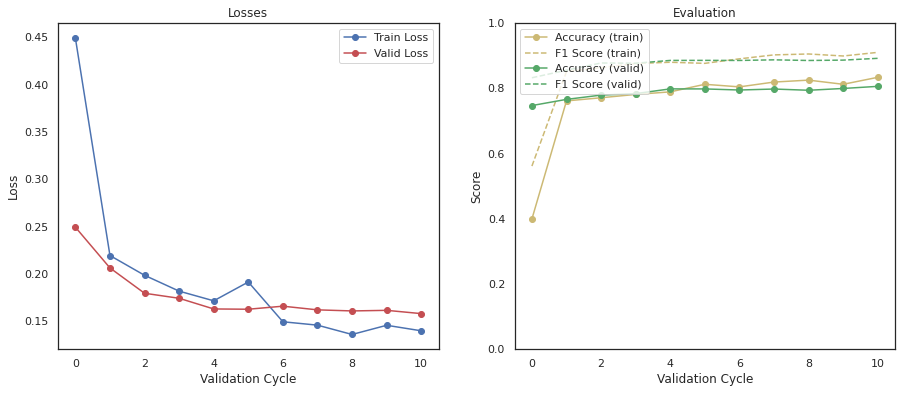

Epoch:  67%|██████▋   | 2/3 [28:01<13:50, 830.45s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1628, Acc: 0.8027, F1: 0.8899
Epoch: 3/3, Loss: 0.1623, Acc: 0.8040, F1: 0.8894
Epoch: 3/3, Loss: 0.1621, Acc: 0.8032, F1: 0.8897
Epoch: 3/3, Loss: 0.1609, Acc: 0.8026, F1: 0.8889
Epoch: 3/3, Loss: 0.1619, Acc: 0.8033, F1: 0.8892

Epoch: 3, Loss: 0.1619, Acc: 0.8033, F1: 0.8892, LR: 2.79e-08



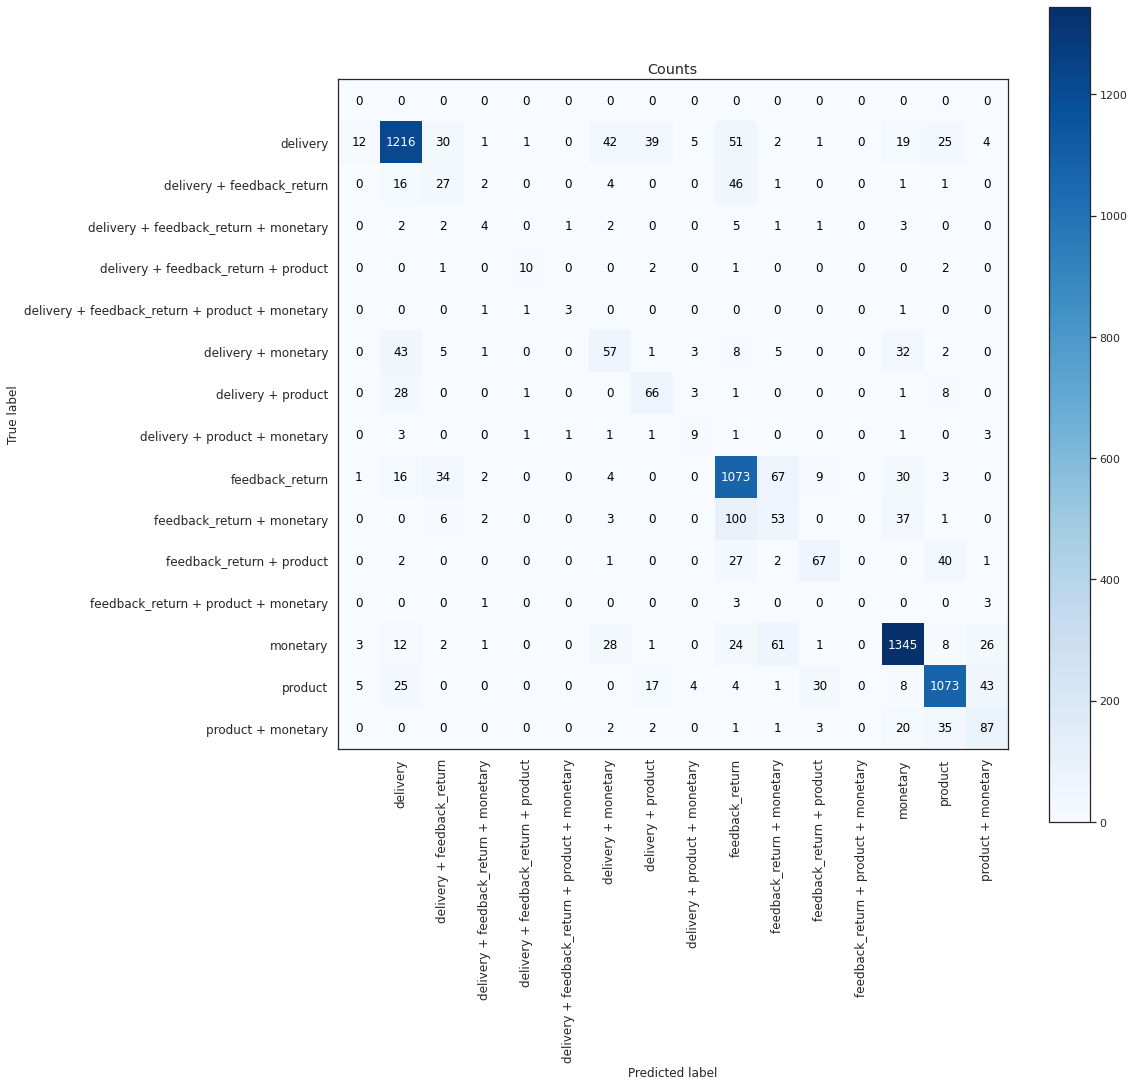

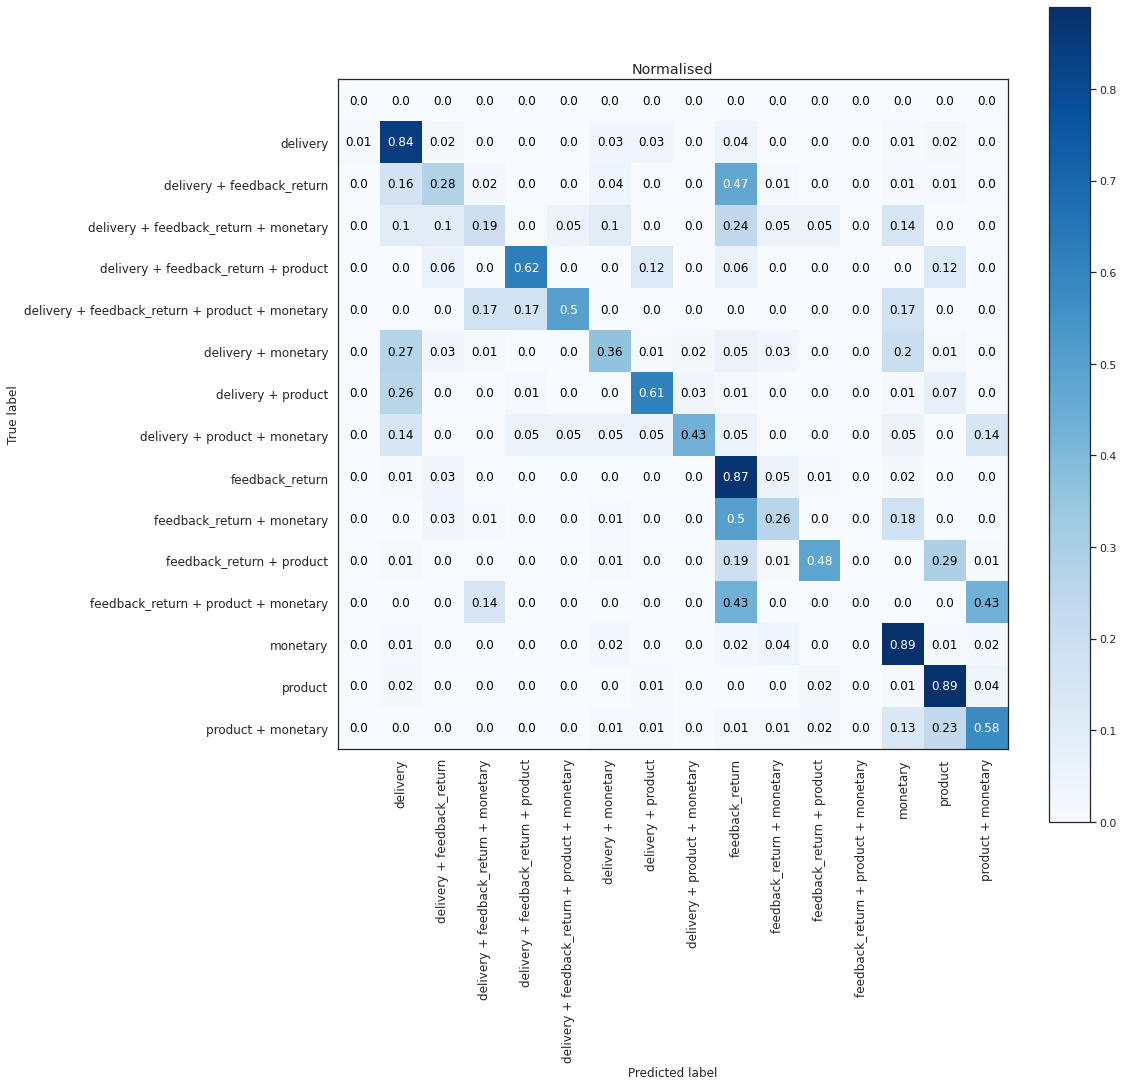

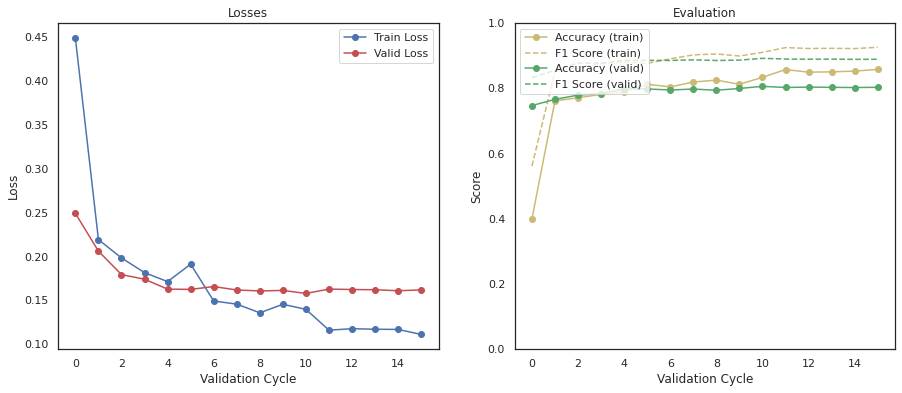

Epoch: 100%|██████████| 3/3 [41:36<00:00, 832.12s/it]


############## cleaning up ###############

############### k-fold: 3 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<<<< length train: 25446
<<<< length validation: 6361


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

class names: {0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}

===== Total Training Steps: 2388 = (796 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.2425, Acc: 0.7514, F1: 0.8393
Epoch: 1/3, Loss: 0.1970, Acc: 0.7691, F1: 0.8632
Epoch: 1/3, Loss: 0.1899, Acc: 0.7735, F1: 0.8663
Epoch: 1/3, Loss: 0.1789, Acc: 0.7880, F1: 0.8735
Epoch: 1/3, Loss: 0.1729, Acc: 0.7884, F1: 0.8795

Epoch: 1, Loss: 0.1729, Acc: 0.7884, F1: 0.8795, LR: 1.48e-05



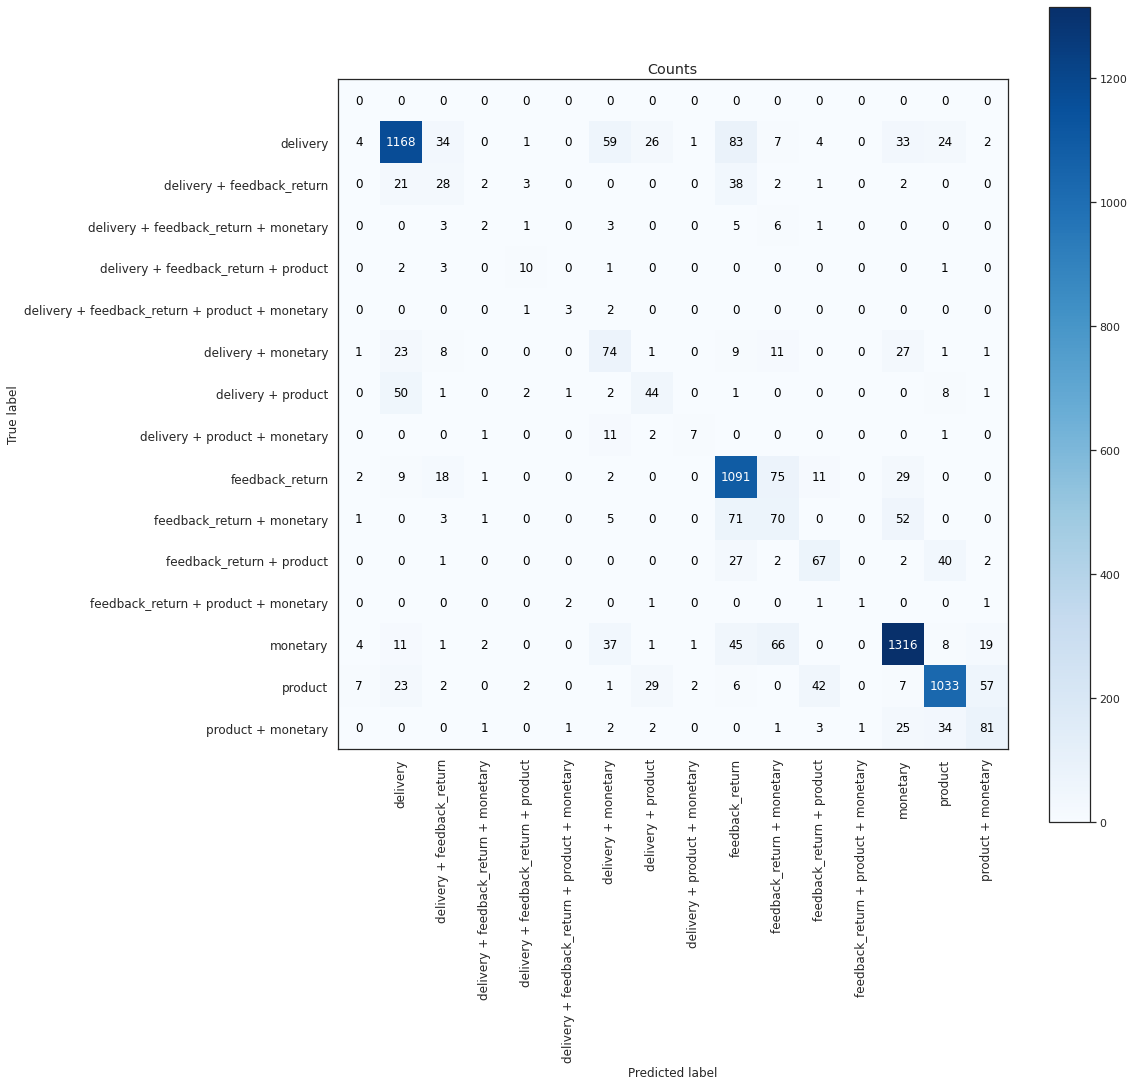

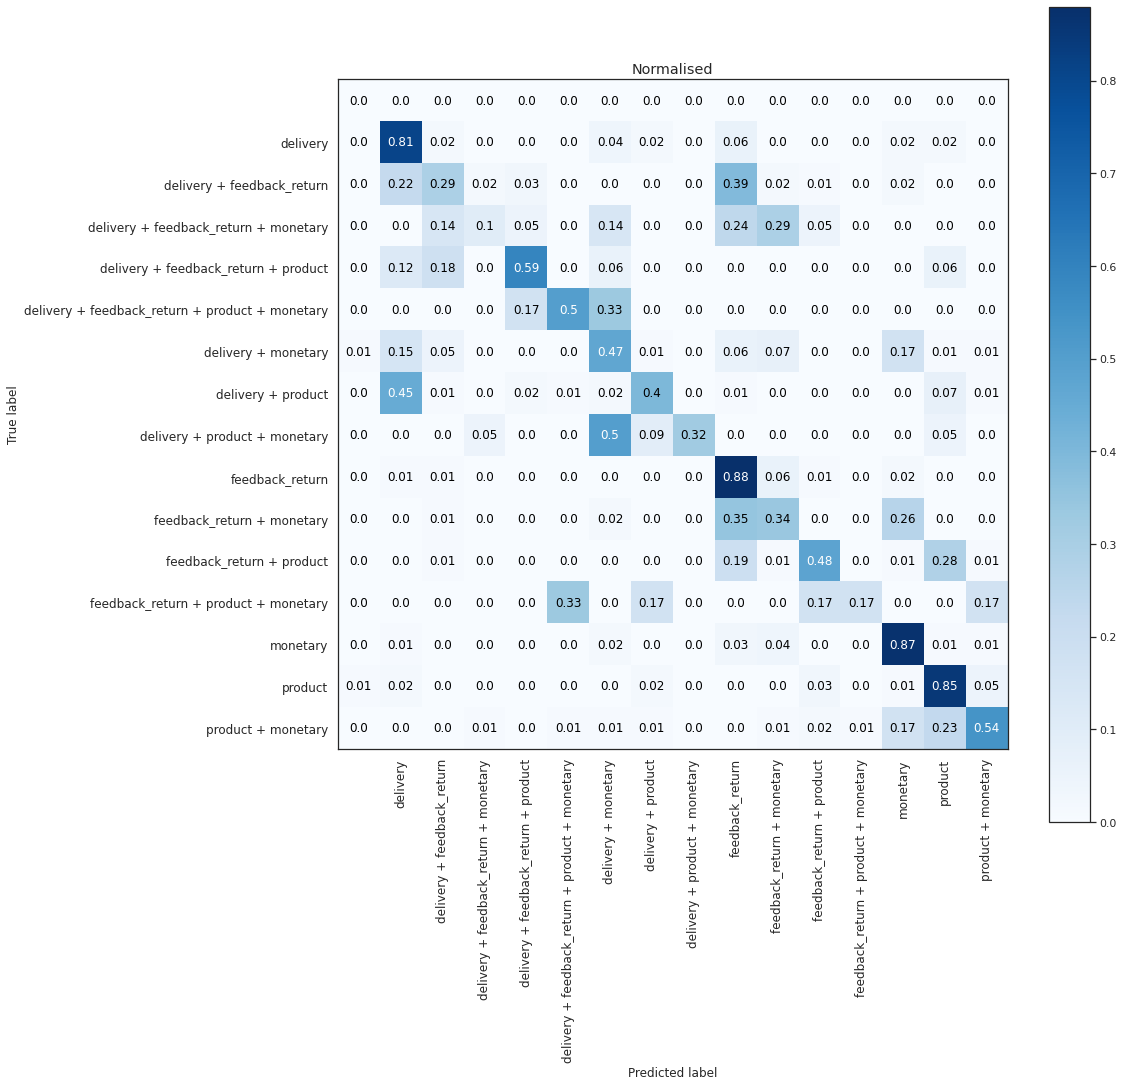

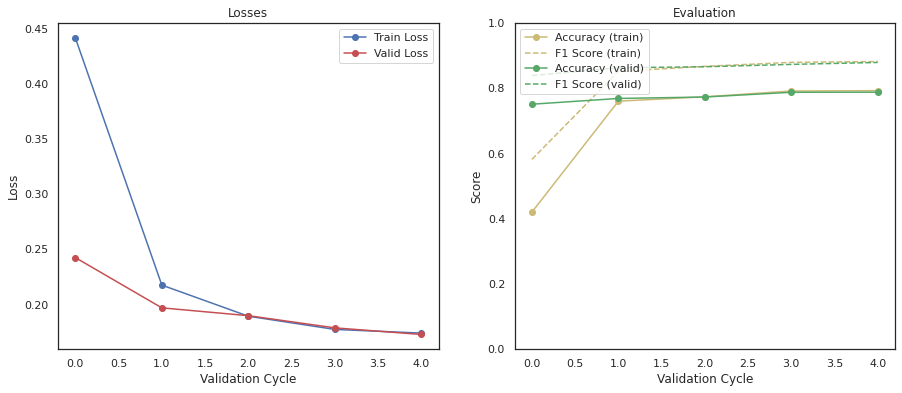

Epoch:  33%|███▎      | 1/3 [13:34<27:08, 814.13s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1742, Acc: 0.7854, F1: 0.8780
Epoch: 2/3, Loss: 0.1789, Acc: 0.7932, F1: 0.8786
Epoch: 2/3, Loss: 0.1712, Acc: 0.7925, F1: 0.8824
Epoch: 2/3, Loss: 0.1724, Acc: 0.7985, F1: 0.8842
Epoch: 2/3, Loss: 0.1691, Acc: 0.7983, F1: 0.8850
Epoch: 2/3, Loss: 0.1674, Acc: 0.7962, F1: 0.8846

Epoch: 2, Loss: 0.1674, Acc: 0.7962, F1: 0.8846, LR: 7.43e-06



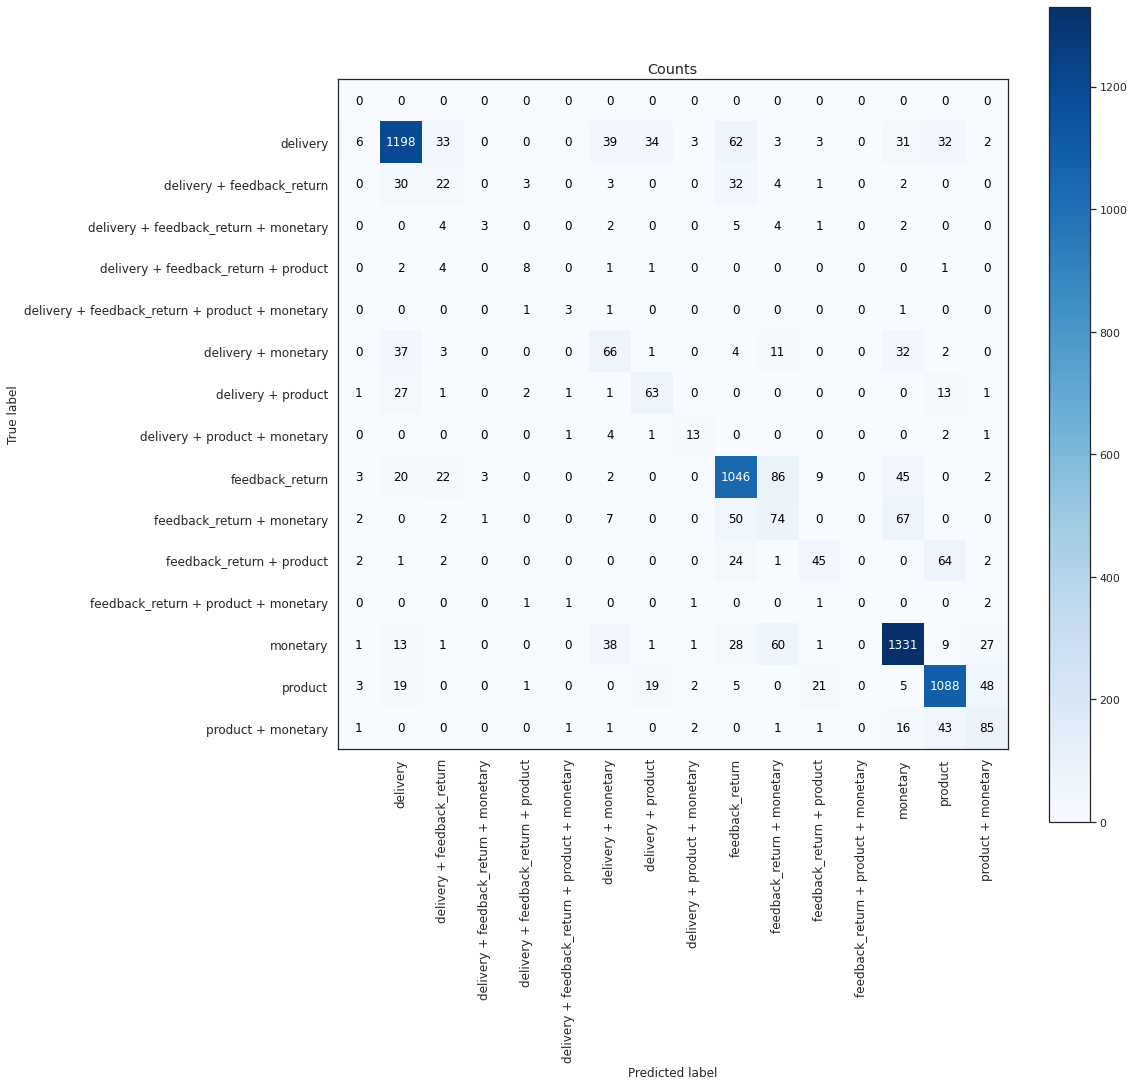

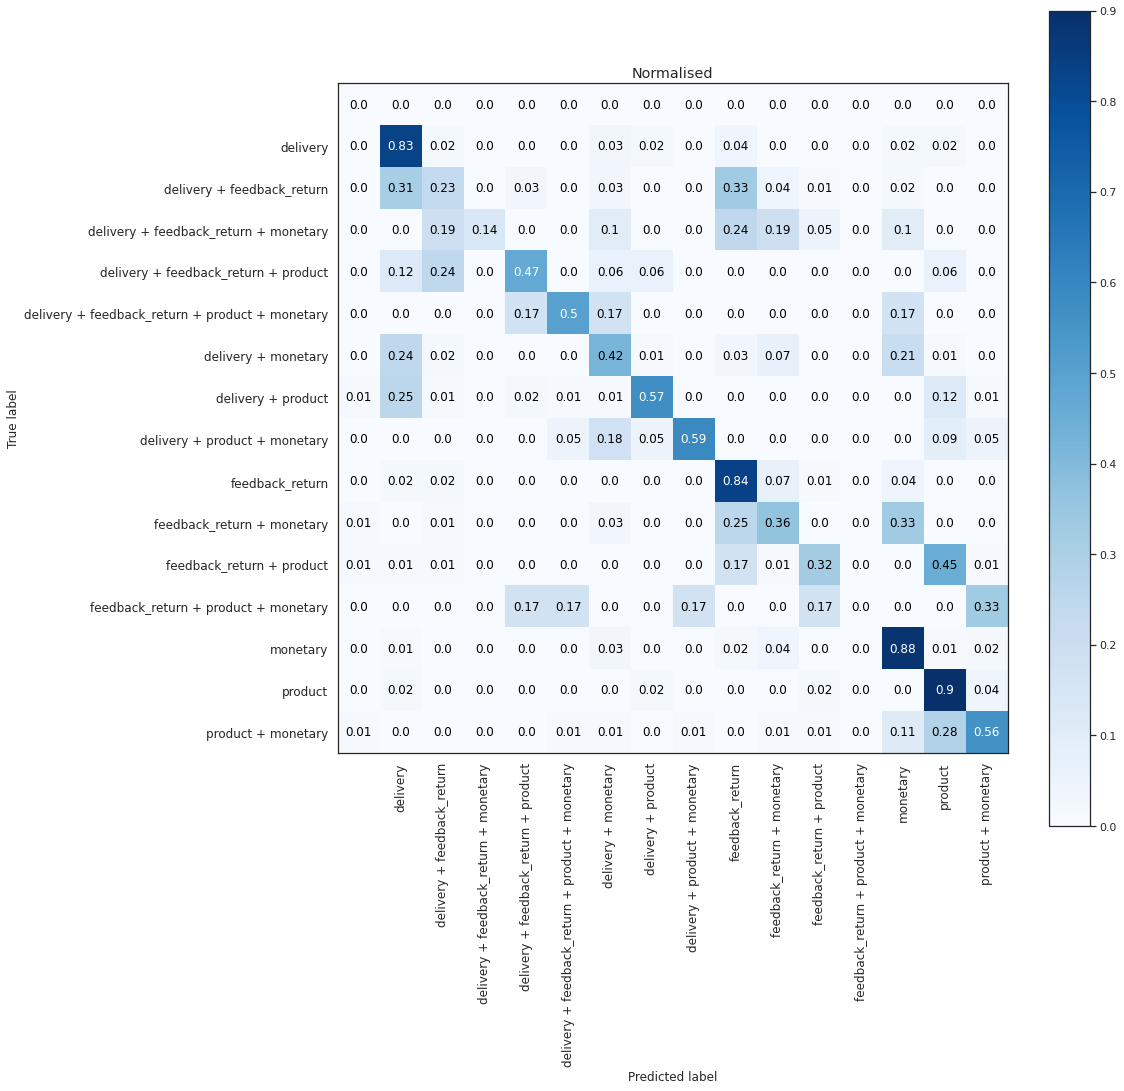

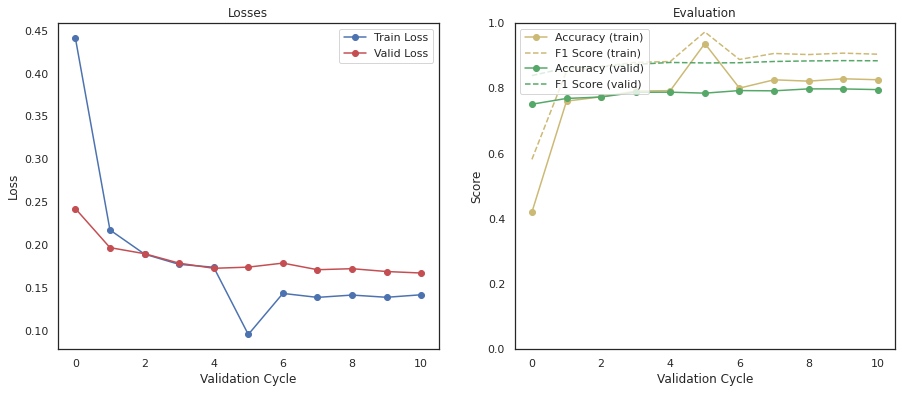

Epoch:  67%|██████▋   | 2/3 [27:59<13:49, 829.57s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1708, Acc: 0.7991, F1: 0.8842
Epoch: 3/3, Loss: 0.1723, Acc: 0.7972, F1: 0.8839
Epoch: 3/3, Loss: 0.1740, Acc: 0.7964, F1: 0.8815
Epoch: 3/3, Loss: 0.1726, Acc: 0.8010, F1: 0.8847
Epoch: 3/3, Loss: 0.1721, Acc: 0.8008, F1: 0.8857

Epoch: 3, Loss: 0.1721, Acc: 0.8008, F1: 0.8857, LR: 2.79e-08



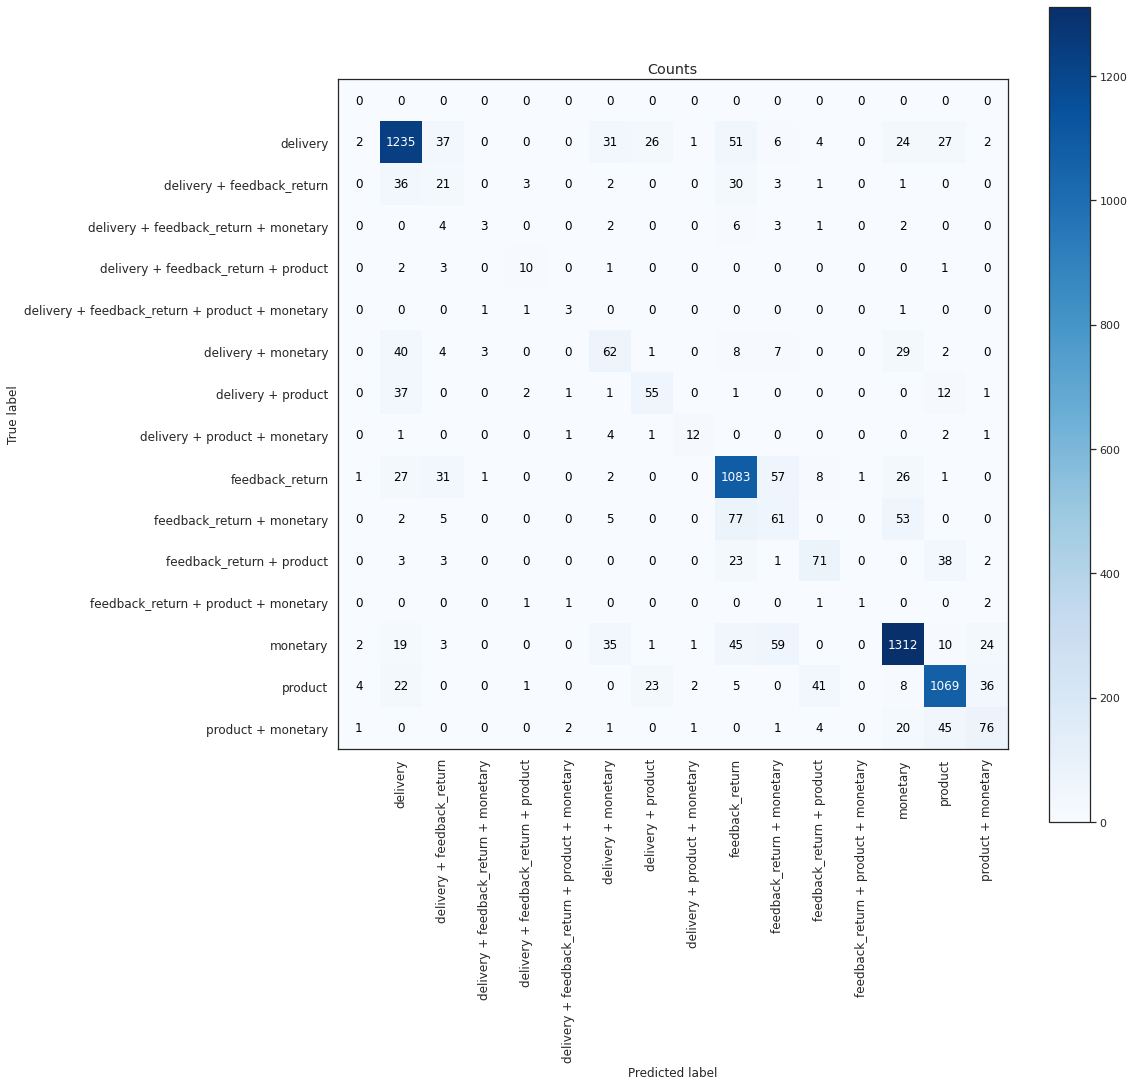

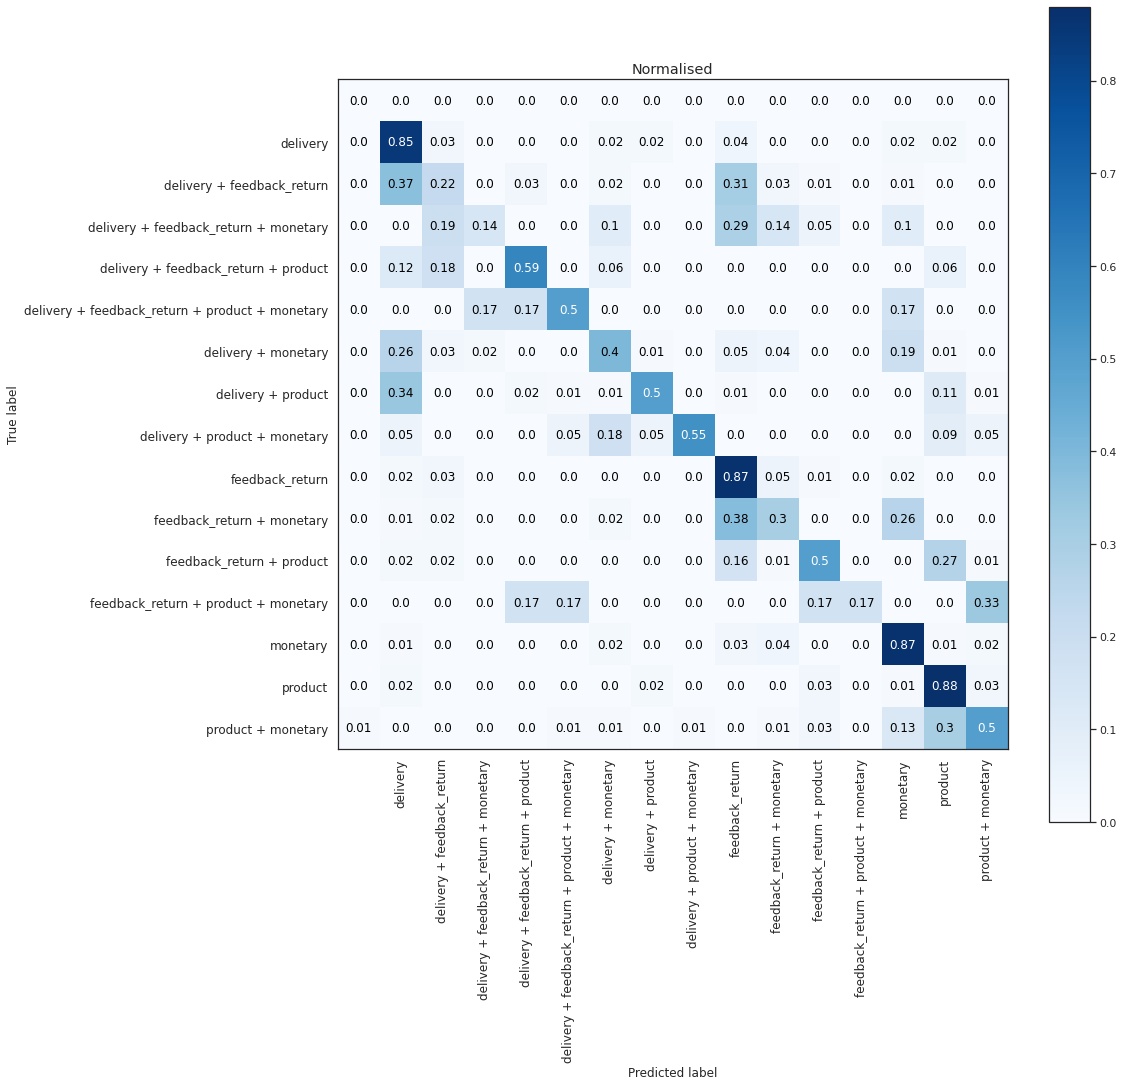

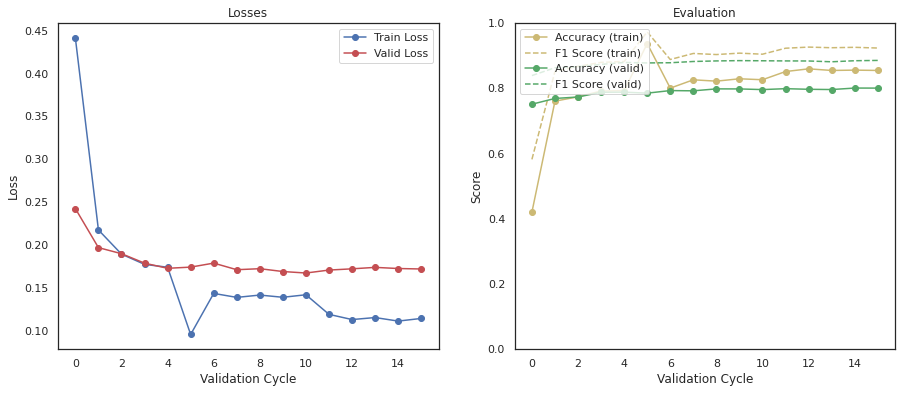

Epoch: 100%|██████████| 3/3 [41:35<00:00, 831.77s/it]


############## cleaning up ###############

############### k-fold: 4 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<<<< length train: 25446
<<<< length validation: 6361


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

class names: {0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}

===== Total Training Steps: 2388 = (796 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.2310, Acc: 0.7642, F1: 0.8496
Epoch: 1/3, Loss: 0.1940, Acc: 0.7697, F1: 0.8654
Epoch: 1/3, Loss: 0.1846, Acc: 0.7816, F1: 0.8688
Epoch: 1/3, Loss: 0.1705, Acc: 0.7884, F1: 0.8789
Epoch: 1/3, Loss: 0.1692, Acc: 0.7939, F1: 0.8809

Epoch: 1, Loss: 0.1692, Acc: 0.7939, F1: 0.8809, LR: 1.48e-05



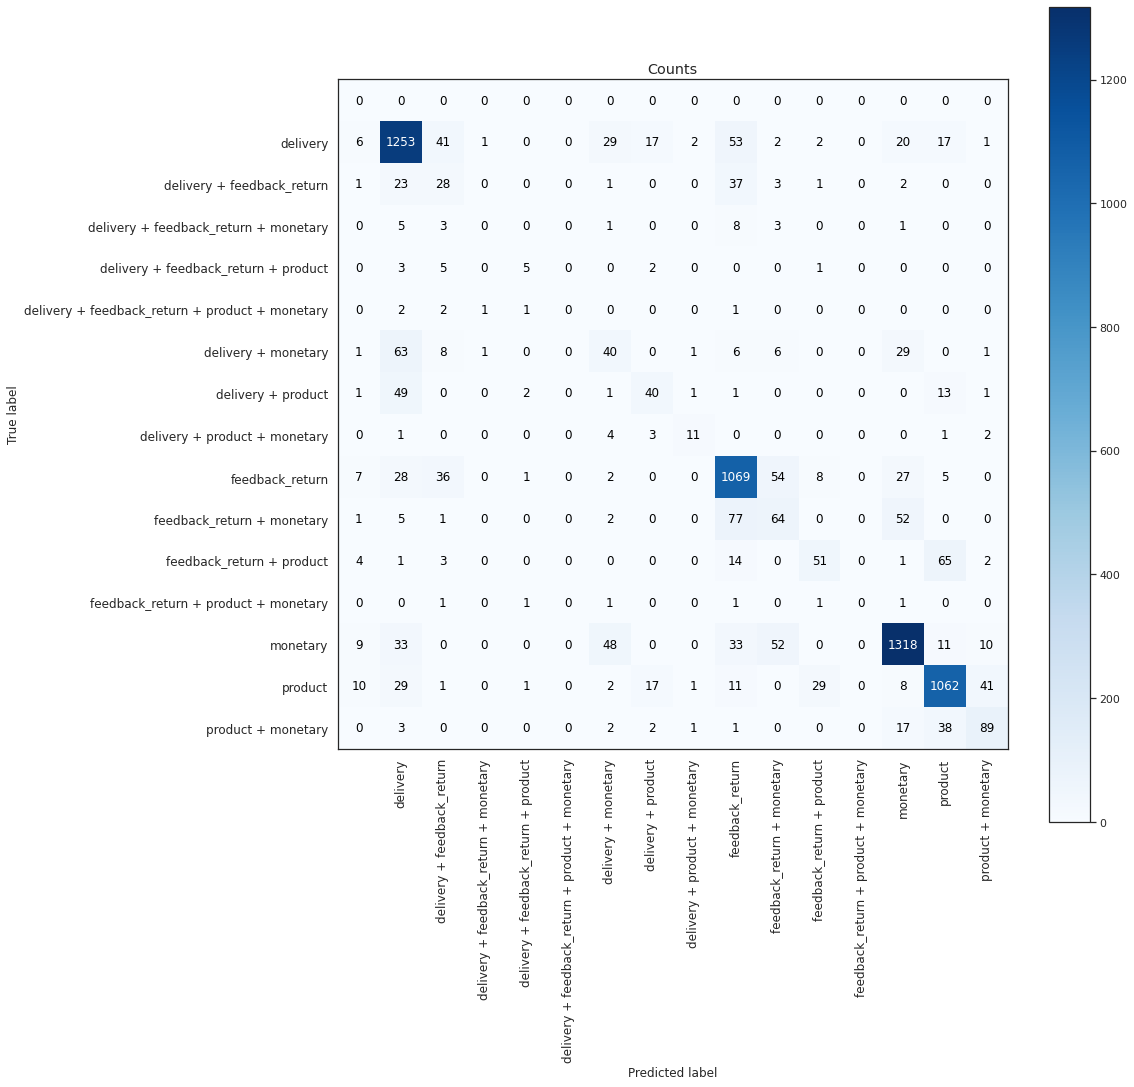

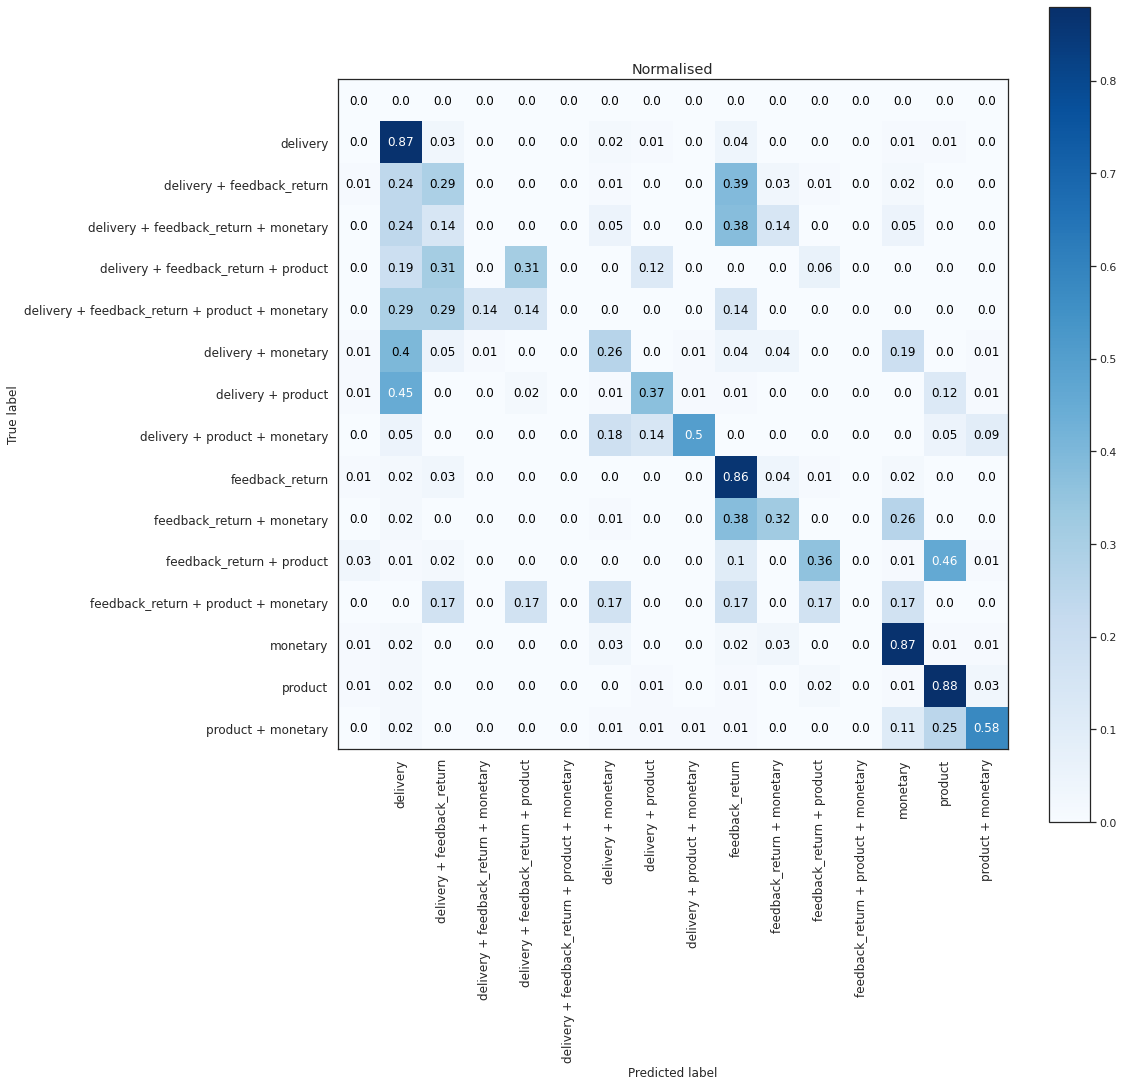

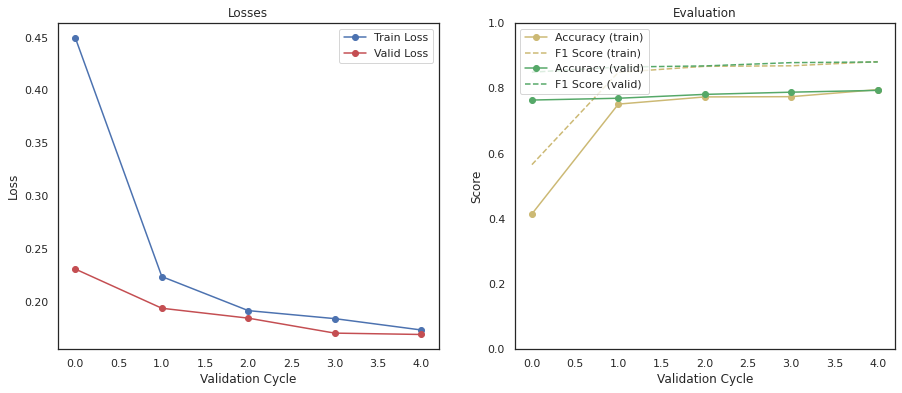

Epoch:  33%|███▎      | 1/3 [13:33<27:06, 813.24s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1688, Acc: 0.7932, F1: 0.8807
Epoch: 2/3, Loss: 0.1704, Acc: 0.7975, F1: 0.8854
Epoch: 2/3, Loss: 0.1711, Acc: 0.7951, F1: 0.8824
Epoch: 2/3, Loss: 0.1672, Acc: 0.8018, F1: 0.8864
Epoch: 2/3, Loss: 0.1659, Acc: 0.8013, F1: 0.8866
Epoch: 2/3, Loss: 0.1673, Acc: 0.8037, F1: 0.8863

Epoch: 2, Loss: 0.1673, Acc: 0.8037, F1: 0.8863, LR: 7.43e-06



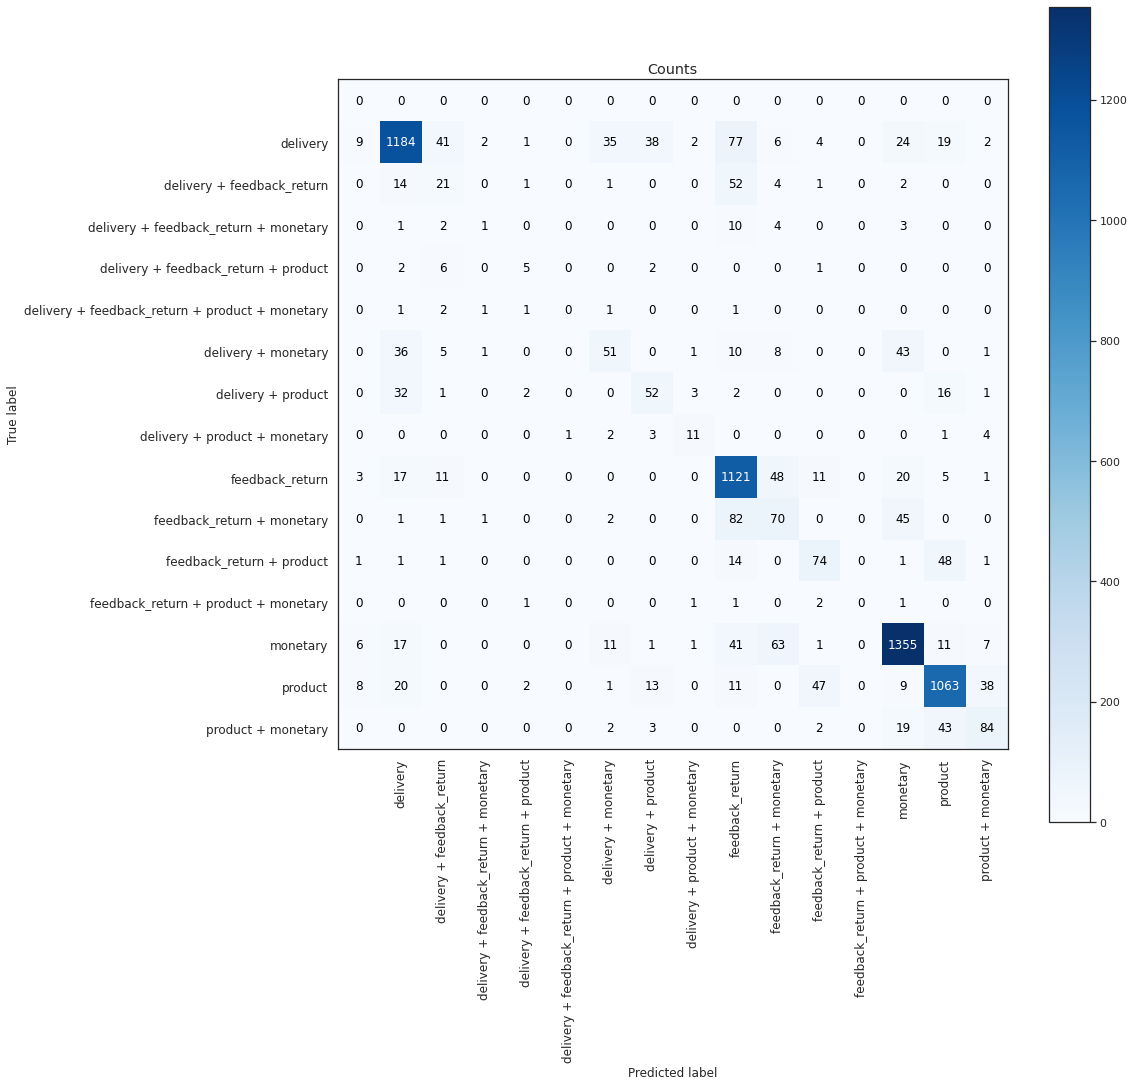

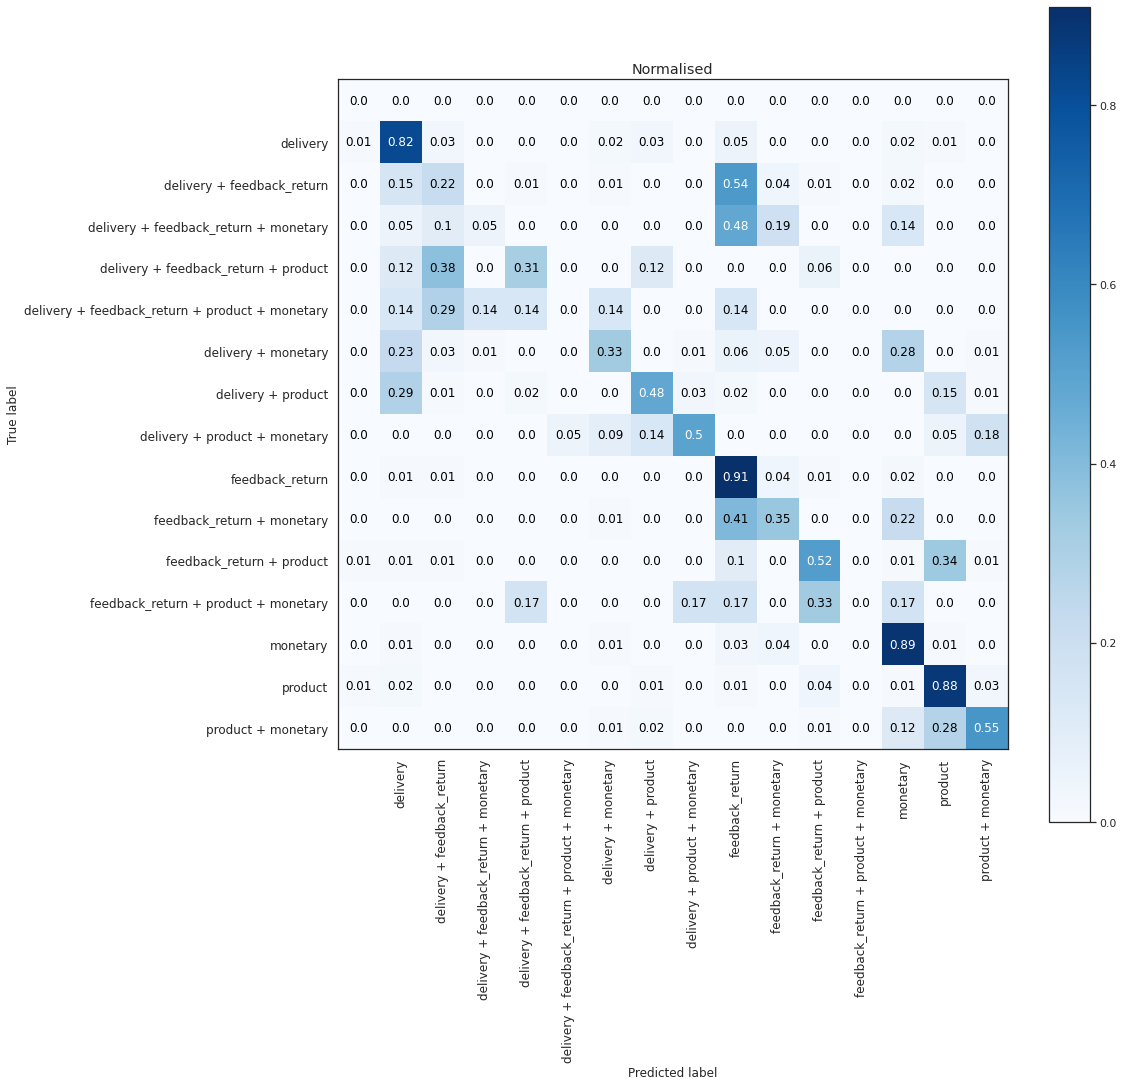

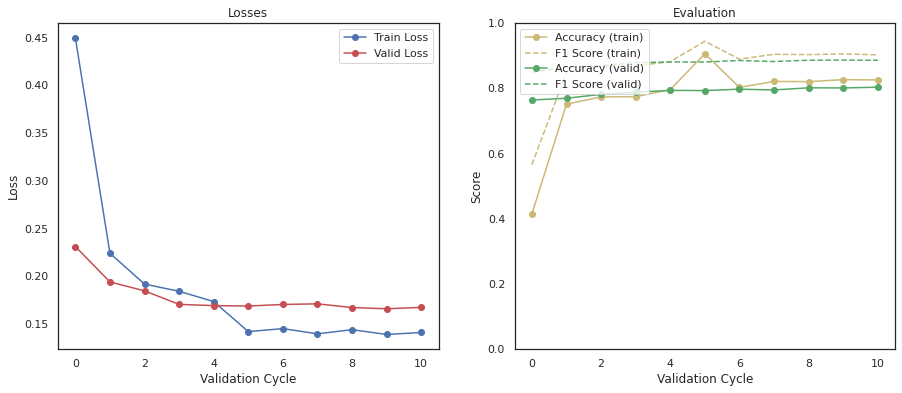

Epoch:  67%|██████▋   | 2/3 [27:58<13:48, 828.86s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1690, Acc: 0.7972, F1: 0.8836
Epoch: 3/3, Loss: 0.1696, Acc: 0.8037, F1: 0.8868
Epoch: 3/3, Loss: 0.1696, Acc: 0.8040, F1: 0.8884
Epoch: 3/3, Loss: 0.1678, Acc: 0.8018, F1: 0.8878
Epoch: 3/3, Loss: 0.1689, Acc: 0.8032, F1: 0.8883

Epoch: 3, Loss: 0.1689, Acc: 0.8032, F1: 0.8883, LR: 2.79e-08



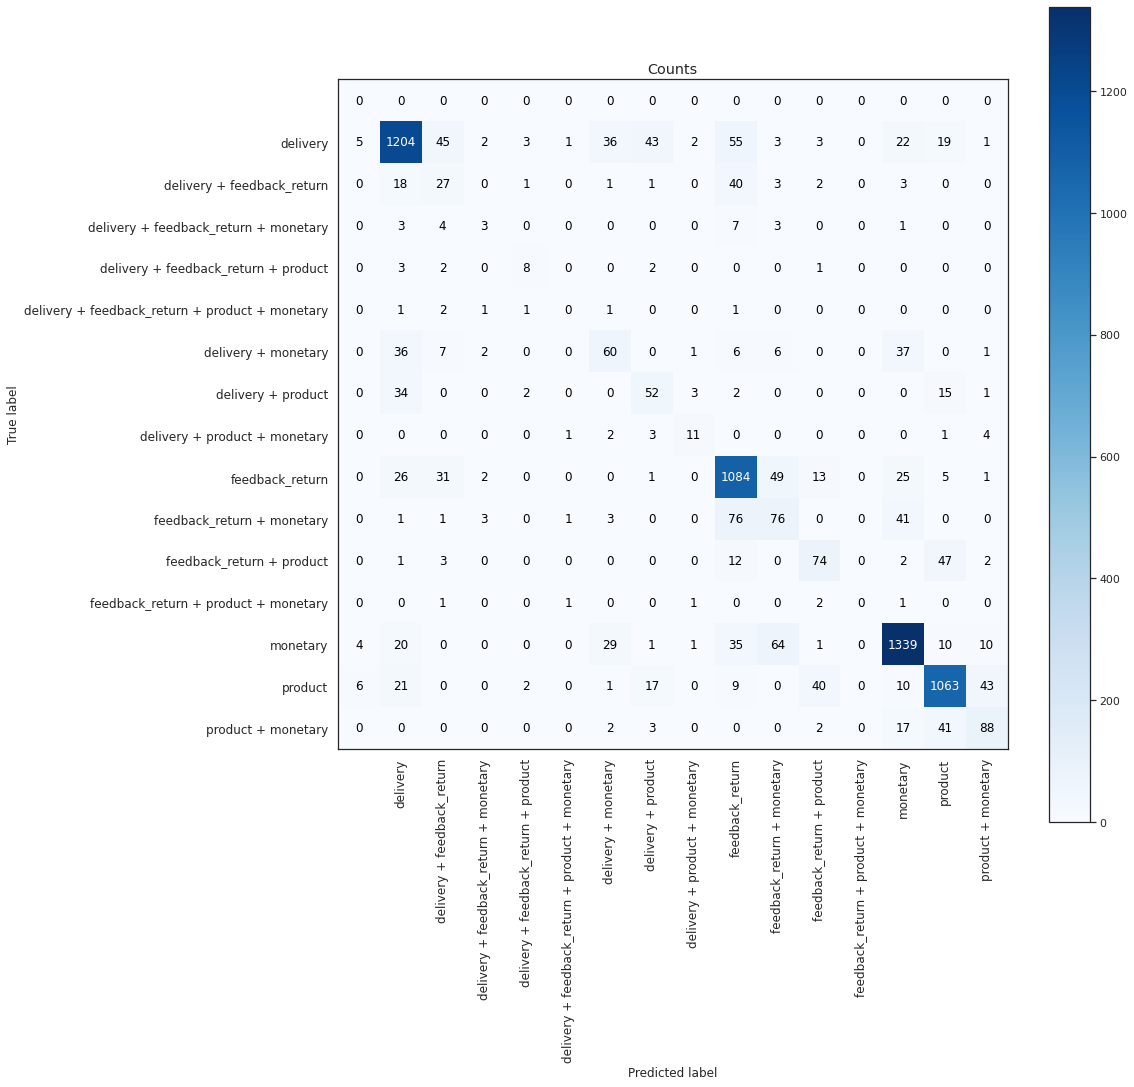

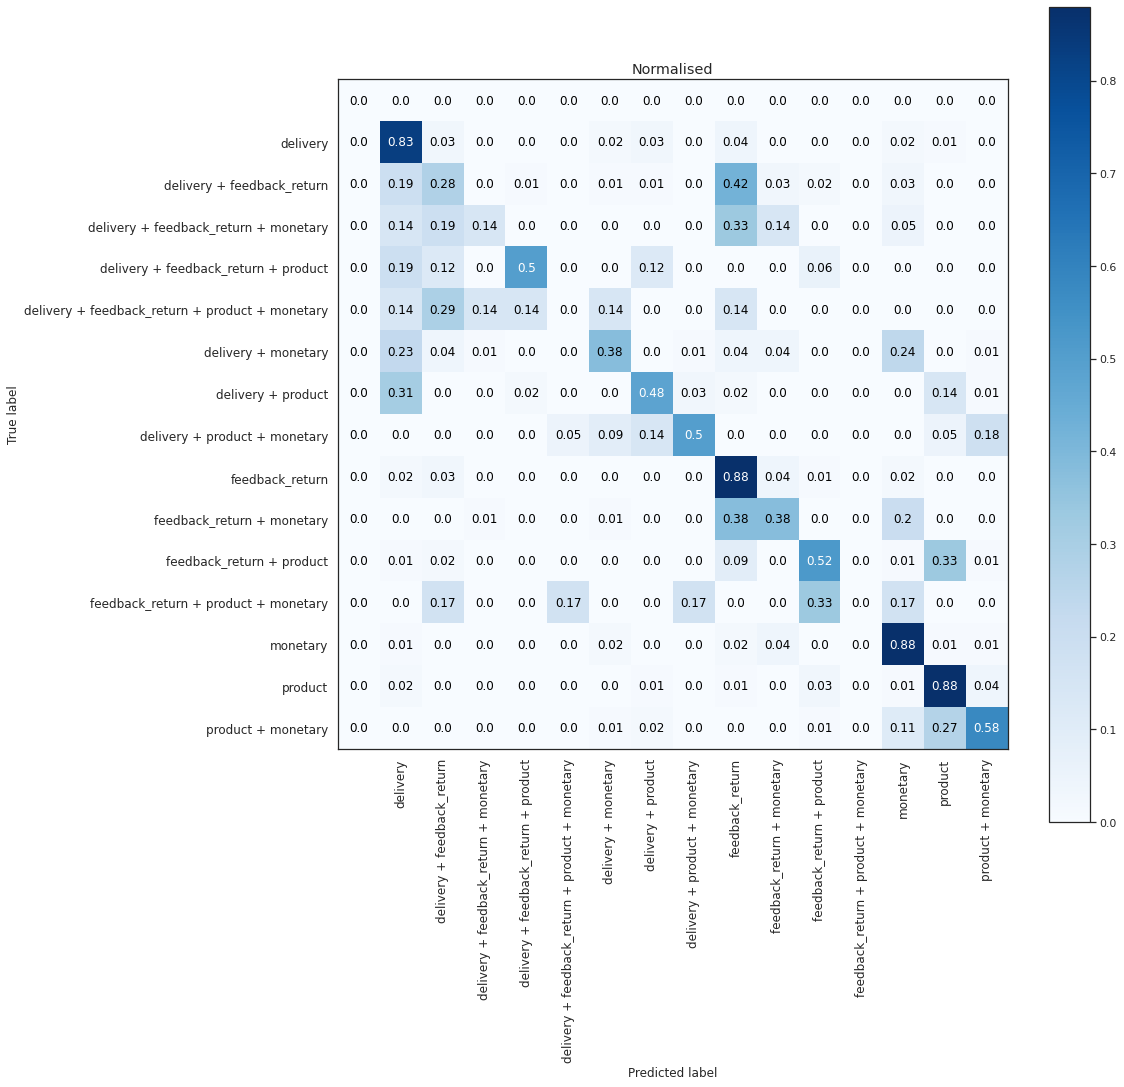

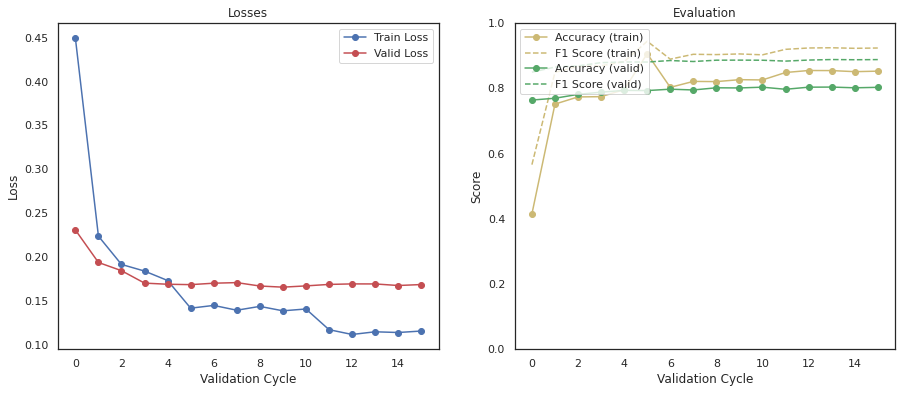

Epoch: 100%|██████████| 3/3 [41:33<00:00, 831.15s/it]


############## cleaning up ###############

############### k-fold: 5 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<<<< length train: 25446
<<<< length validation: 6361


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

class names: {0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}

===== Total Training Steps: 2388 = (796 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.2432, Acc: 0.7538, F1: 0.8396
Epoch: 1/3, Loss: 0.1970, Acc: 0.7707, F1: 0.8652
Epoch: 1/3, Loss: 0.1759, Acc: 0.7918, F1: 0.8803
Epoch: 1/3, Loss: 0.1674, Acc: 0.7951, F1: 0.8861
Epoch: 1/3, Loss: 0.1626, Acc: 0.7921, F1: 0.8865

Epoch: 1, Loss: 0.1626, Acc: 0.7921, F1: 0.8865, LR: 1.48e-05



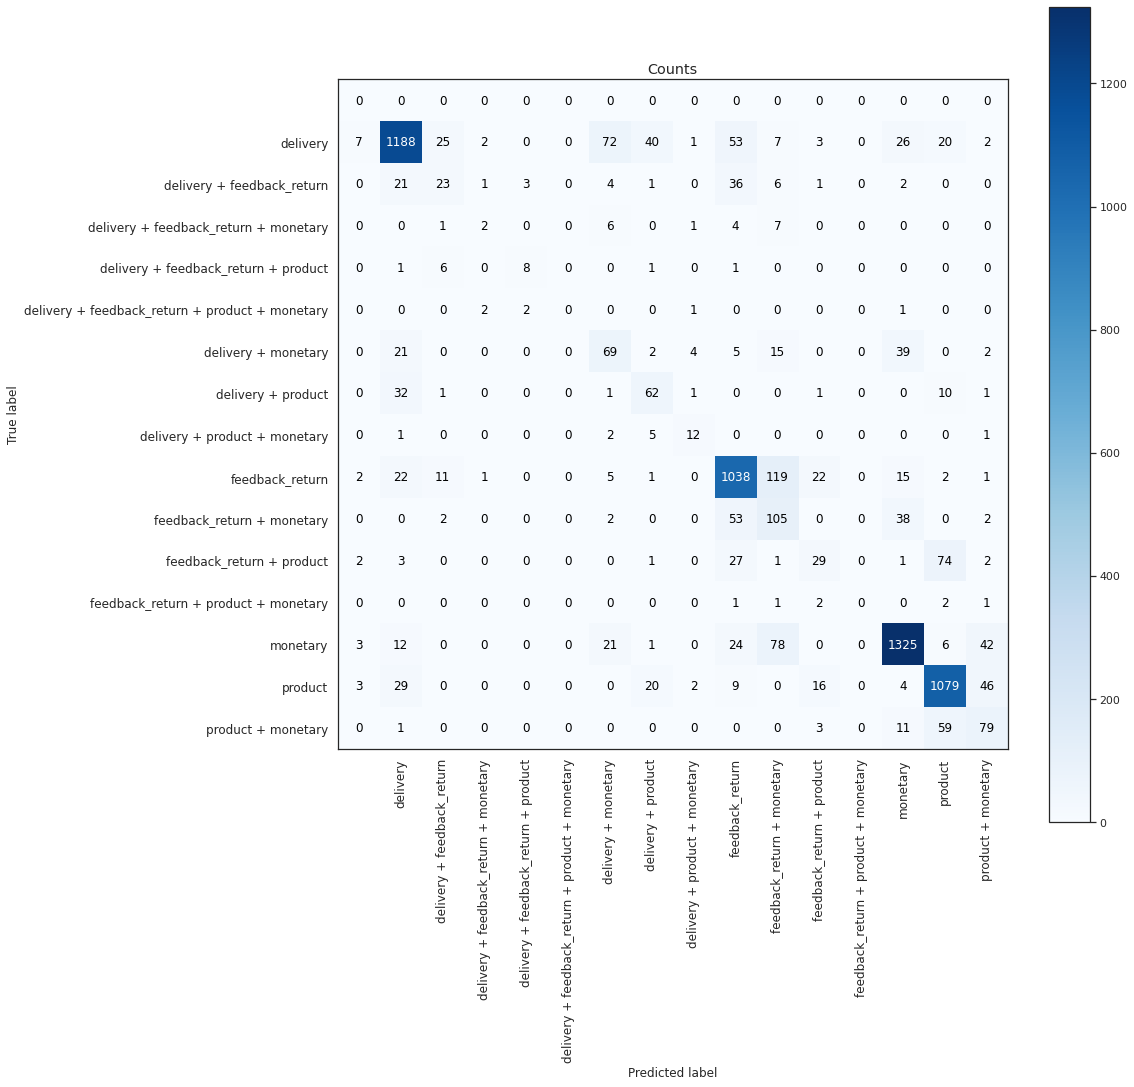

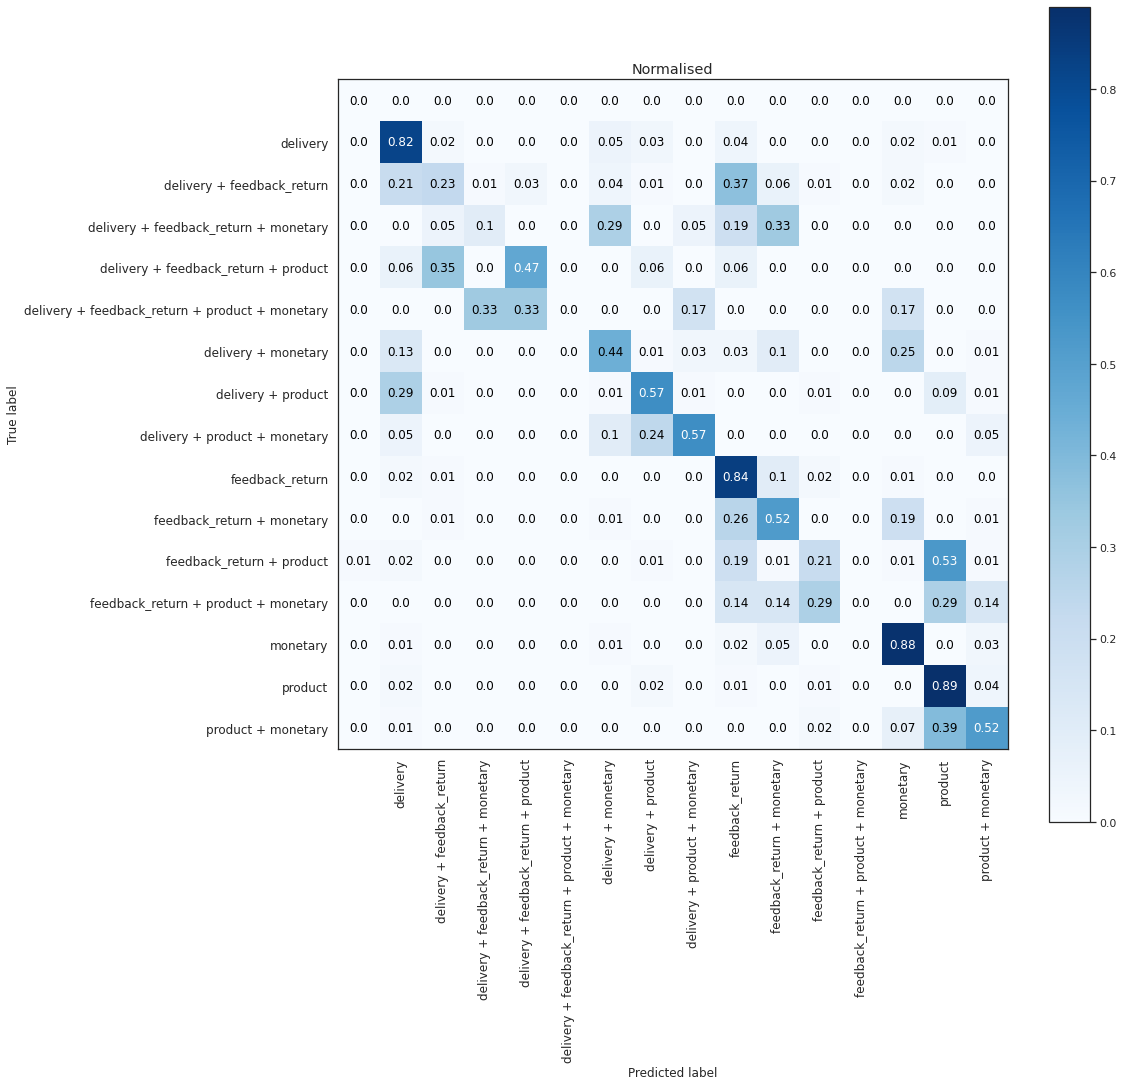

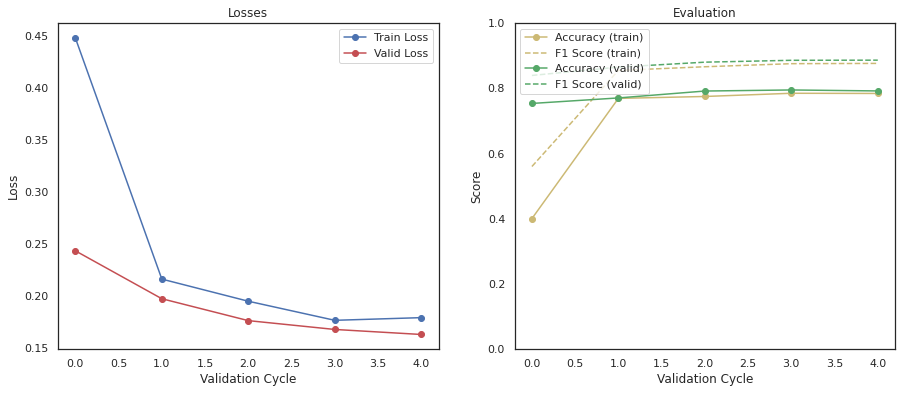

Epoch:  33%|███▎      | 1/3 [13:34<27:09, 814.94s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1625, Acc: 0.7918, F1: 0.8865
Epoch: 2/3, Loss: 0.1621, Acc: 0.7926, F1: 0.8864
Epoch: 2/3, Loss: 0.1613, Acc: 0.7939, F1: 0.8878
Epoch: 2/3, Loss: 0.1651, Acc: 0.7985, F1: 0.8863
Epoch: 2/3, Loss: 0.1593, Acc: 0.8040, F1: 0.8911
Epoch: 2/3, Loss: 0.1588, Acc: 0.8007, F1: 0.8898

Epoch: 2, Loss: 0.1588, Acc: 0.8007, F1: 0.8898, LR: 7.43e-06



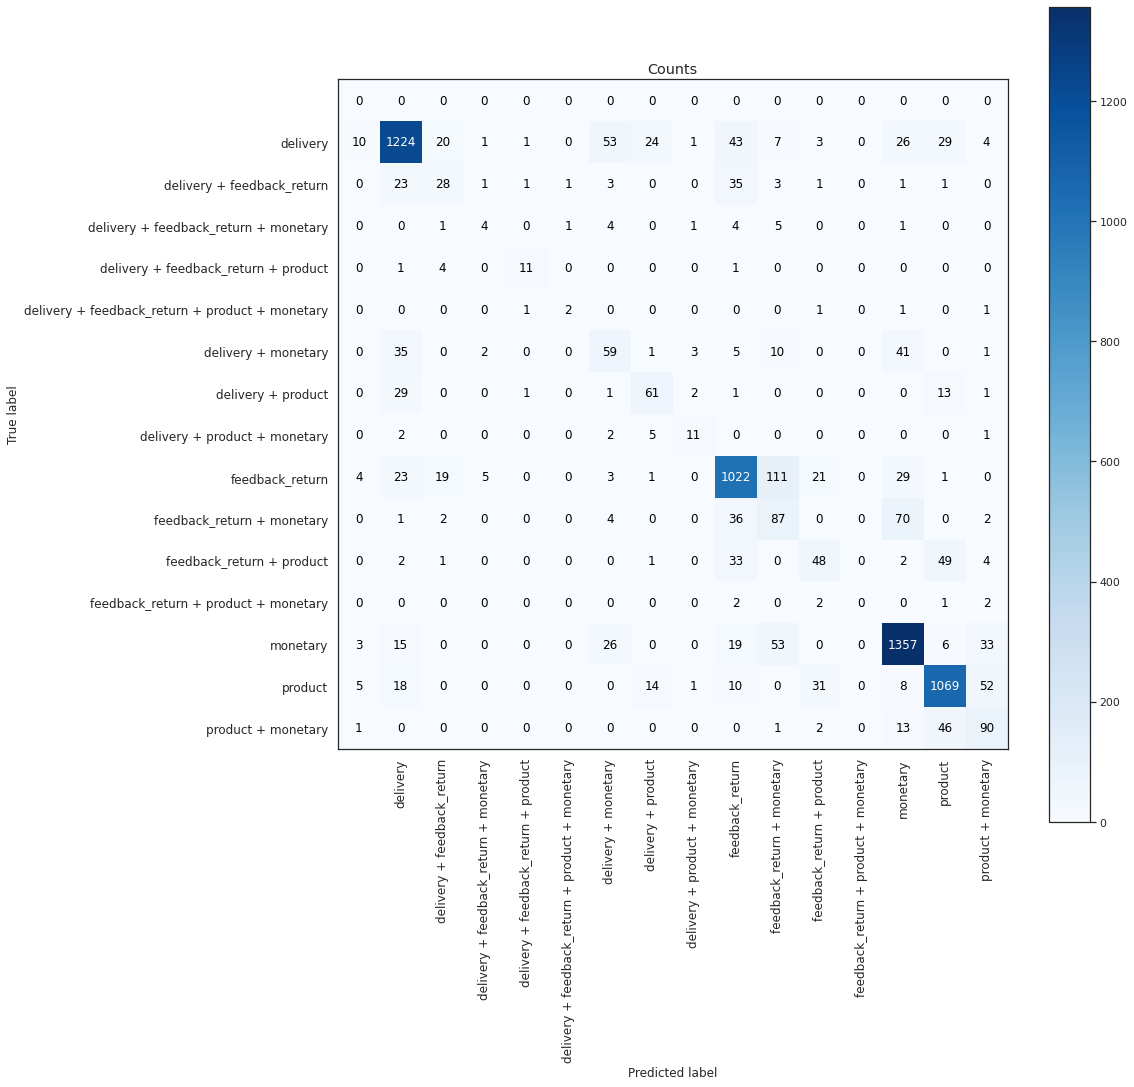

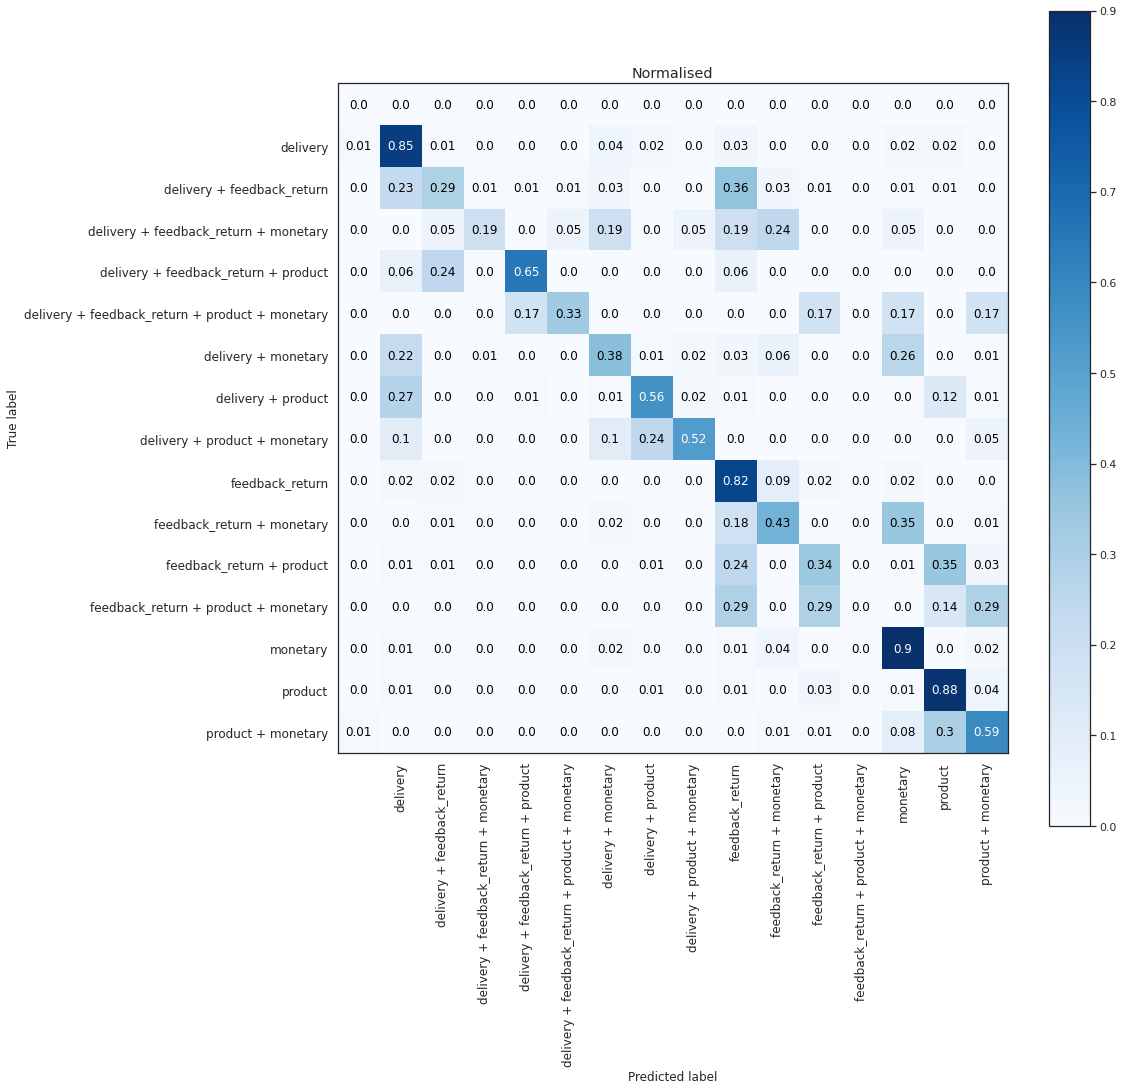

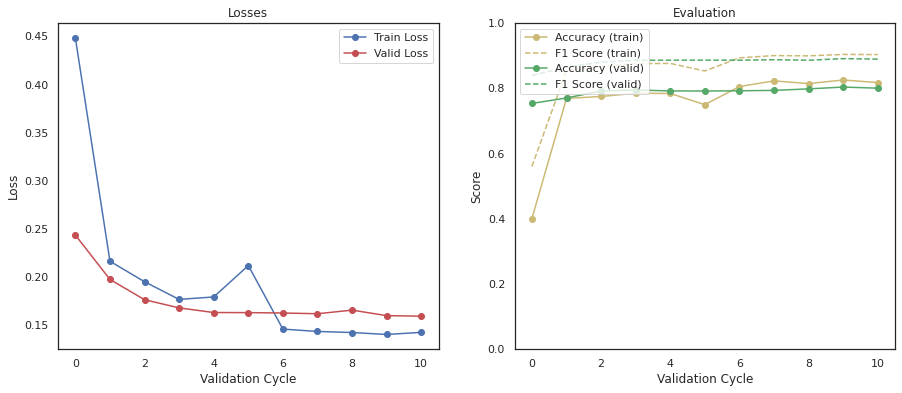

Epoch:  67%|██████▋   | 2/3 [28:02<13:50, 830.78s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1638, Acc: 0.8041, F1: 0.8907
Epoch: 3/3, Loss: 0.1635, Acc: 0.8003, F1: 0.8908
Epoch: 3/3, Loss: 0.1641, Acc: 0.8024, F1: 0.8916
Epoch: 3/3, Loss: 0.1622, Acc: 0.8029, F1: 0.8908
Epoch: 3/3, Loss: 0.1621, Acc: 0.8022, F1: 0.8912

Epoch: 3, Loss: 0.1621, Acc: 0.8022, F1: 0.8912, LR: 2.79e-08



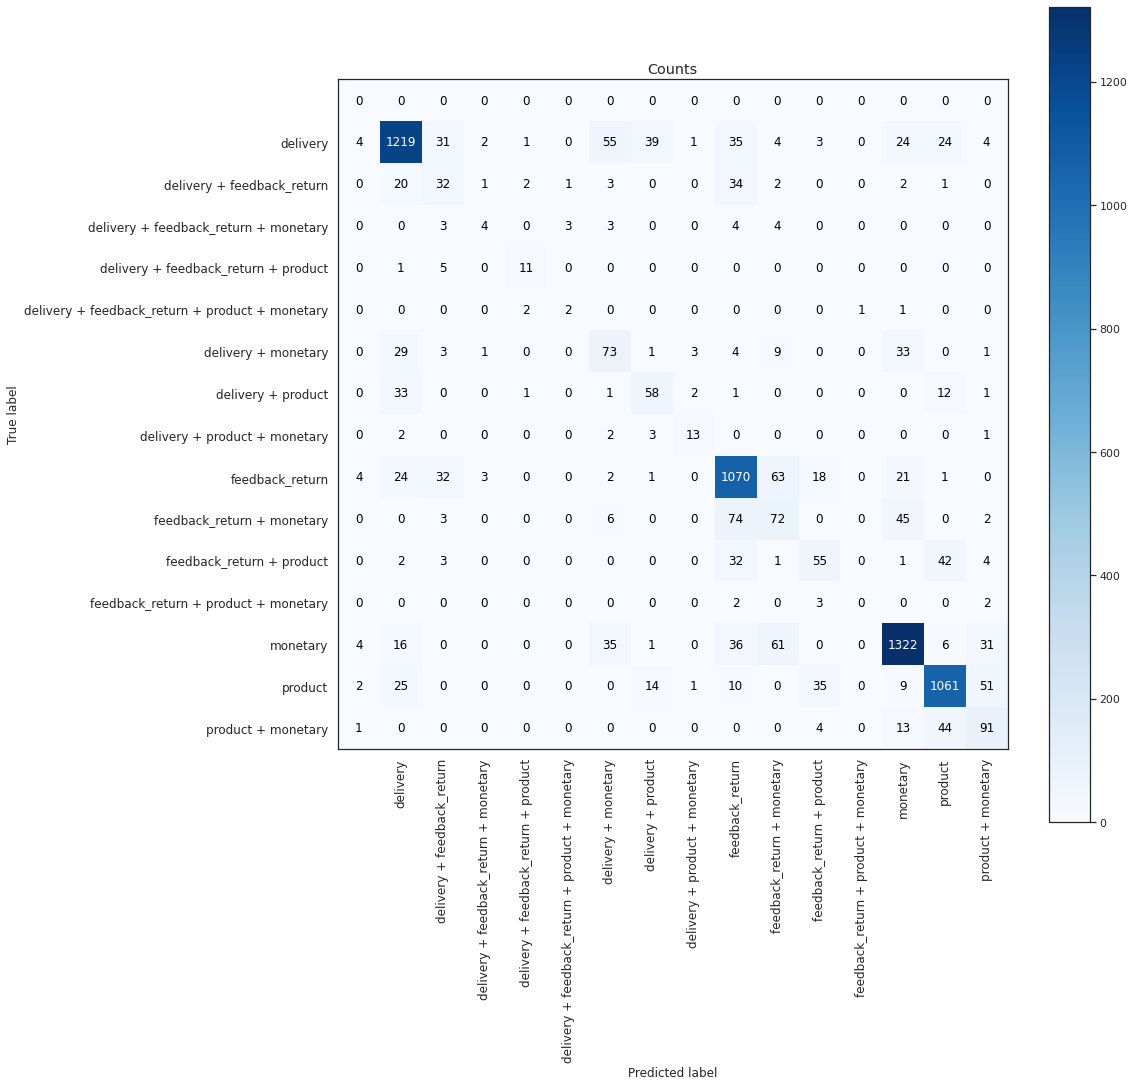

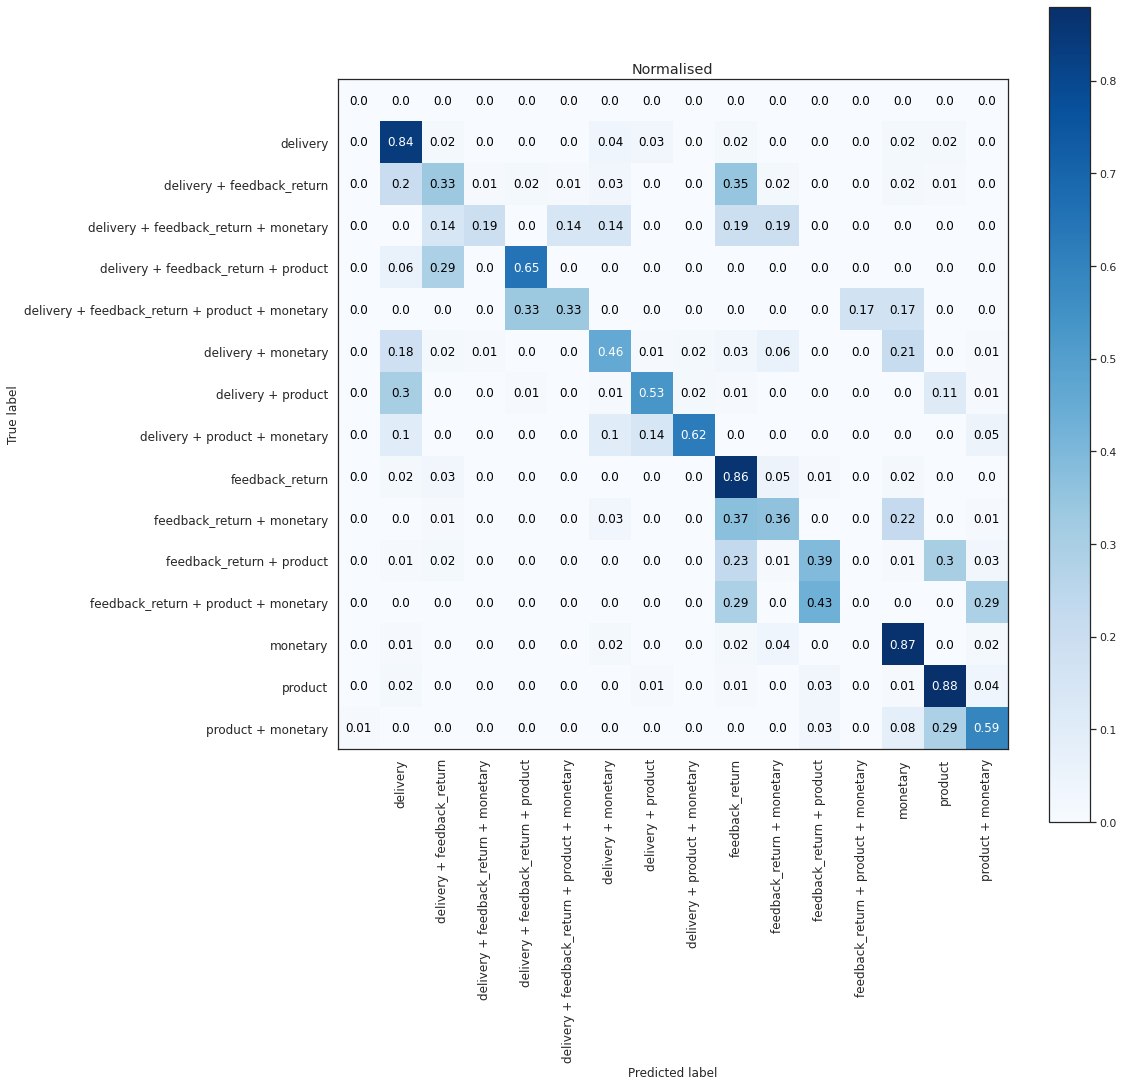

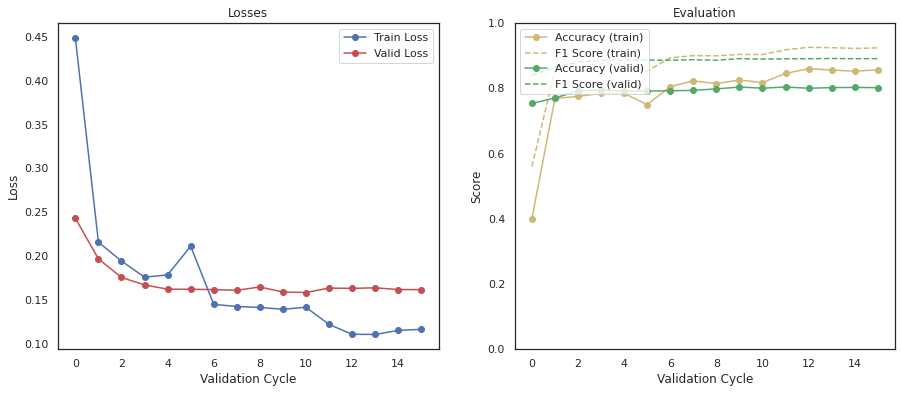

Epoch: 100%|██████████| 3/3 [41:39<00:00, 833.10s/it]


############## cleaning up ###############
Process Time (sec): 12502.982265506
acc: 0.8022, f1: 0.8912, duration: 12.502982265506
CPU times: user 1h 52min, sys: 1h 35min 58s, total: 3h 27min 59s
Wall time: 3h 28min 22s


In [ ]:
%%time
loss_folds, acc_folds, f1_folds, model_final = train(MODEL_PATH, 
                                         NUM_LABELS, 
                                         UNIQUE_LABELS,
                                         texts, 
                                         labels, 
                                         EPOCHS, 
                                         PATIENCE, 
                                         BATCH_SIZE, 
                                         SEQ_LEN, 
                                         LR)

In [ ]:
results = pd.DataFrame({ "loss": loss_folds, "acc": acc_folds, "f1": f1_folds })
results

loss       acc        f1
0  0.165242  0.795139  0.887202
1  0.161888  0.803346  0.889193
2  0.172072  0.800821  0.885712
3  0.168854  0.803188  0.888252
4  0.162054  0.802241  0.891185

In [ ]:
results.to_csv(RESULTS_PATH)
results.mean()

loss    0.166022
acc     0.800947
f1      0.888309
dtype: float64

# (experimental) Optimizing for F1 score
* This section trys to define the optimal threshold value for by finding the best F1 score instead of the empirical approach
* In its current state, the empirical approach is actually presentable for the prototype. This is simply a possible approach for improvements
* Needs to have true labels so we get this from the subset we made above (X_test, y_test)
* Conclusion: Shows minimal signs of improvements but needs more time to make this approach work. Using the empirical threshold value for now  




In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
model.load_state_dict(torch.load(MODEL_PATH))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

<All keys matched successfully>

In [ ]:
test_df = pd.read_csv(DATA_NO_LABELS)

In [ ]:
# Gathering input data
test_texts = test_df["feedback_text_en"].astype(str).tolist()
texts = preprocess(test_texts) # Make sure to pre-process identically to training phase

In [ ]:
class DatasetPredict(Dataset):
    def __init__(self, x):
        self.datalist=[(x[i]) for i in range(len(x))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]

In [ ]:
def predict_mlc(model, tokenizer, texts, batch_size, seq_len, true_labels=None):
    # Instead of TensorDataset since I will encode during model training
    if true_labels:
        test_data = DatasetPair(texts, true_labels)
    else:
        test_data = DatasetPredict(texts)

    # DataLoaders instead of conventional for loops to avoid memory issue during training
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.to(device)
    model.eval()

    y_true, y_preds = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            if true_labels:
                text_batch, labels = batch
            else:
                text_batch = batch

            text_encoded = tokenizer.batch_encode_plus(text_batch, 
                            max_length=seq_len, 
                            pad_to_max_length=True,
                            truncation=True,
                            return_tensors="pt").to(device)
            outputs = model(**text_encoded) 
            logits = outputs[0]    
            y_preds.append(torch.sigmoid(logits).to('cpu').numpy())
            y_true.append(labels.to('cpu').numpy())
          
    return y_true, y_preds

In [ ]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. 

def get_best_threshold(true_bools, pred_labels):
    macro_thresholds = np.array(range(1, 10)) / 10

    f1_results_tmp, f1_results, flat_acc_results = [], [], []
    for th in macro_thresholds:
        pred_bools = [pl > th for pl in pred_labels]
        
        f1 = f1_score(true_bools, pred_bools, average='micro')
        f1_results_tmp.append(f1)

    best_macro_th = macro_thresholds[np.argmax(f1_results_tmp)] 

    micro_thresholds = (np.array(range(10)) / 100) + best_macro_th

    for th in micro_thresholds:
        pred_bools = [pl > th for pl in pred_labels]

        f1 = f1_score(true_bools, pred_bools, average='micro')
        acc = accuracy_score(true_bools, pred_bools)

        f1_results.append(f1)
        flat_acc_results.append(acc)

    best_f1_idx = np.argmax(f1_results) #best threshold value
    best_threshold = micro_thresholds[best_f1_idx]

    print('Best Threshold: ', best_threshold)
    print('Test F1 Accuracy: ', f1_results[best_f1_idx])
    print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

    return best_threshold

In [ ]:
y_truth, y_pred = predict_mlc(model, tokenizer, X_test, batch_size, seq_len, y_test)

In [ ]:
pred_classes = get_multiclass_labels(class_names, 0.5, y_pred)

In [ ]:
default_threshold = 0.5
class_names = dict(zip(range(num_labels), cols))

cls_report = get_cls_report(class_names, default_threshold, y_truth, y_pred) 
print(cls_report)

target_names <true>: {'', 'delivery + feedback_return + product + monetary', 'delivery + feedback_return', 'feedback_return + product', 'delivery + monetary', 'delivery + product + monetary', 'product', 'delivery + feedback_return + product', 'feedback_return', 'delivery + feedback_return + monetary', 'monetary', 'product + monetary', 'delivery + product', 'feedback_return + monetary', 'feedback_return + product + monetary', 'delivery'}
target_names <pred>: {'product', '', 'delivery + feedback_return + product', 'feedback_return', 'delivery + feedback_return + monetary', 'monetary', 'delivery + feedback_return + product + monetary', 'delivery + feedback_return', 'product + monetary', 'feedback_return + product', 'delivery + monetary', 'delivery + product + monetary', 'delivery + product', 'feedback_return + monetary', 'feedback_return + product + monetary', 'delivery'}
                                                 precision    recall  f1-score   support

                            

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
true_labels = [item for sublist in y_test for item in sublist]
true_bools = [true == 1 for true in true_labels]
pred_labels = [item for sublist in y_pred for items in sublist for item in items]

In [ ]:
pred_labels[0]

0.0050498857

In [ ]:
best_threshold = get_best_threshold(true_bools, pred_labels)

Best Threshold:  0.62
Test F1 Accuracy:  0.9324897830870795
Test Flat Accuracy:  0.9324897830870795 



In [ ]:
cls_report = get_cls_report(class_names, best_threshold, y_truth, y_pred) 
print(cls_report)

                                                 precision    recall  f1-score   support

                                                      0.00      0.00      0.00         0
                                       delivery       0.86      0.88      0.87       726
                            delivery + monetary       0.48      0.24      0.32        49
                     delivery + feedback_return       0.00      0.00      0.00        11
delivery + feedback_return + product + monetary       0.62      0.62      0.62         8
                                feedback_return       0.50      0.33      0.40         3
                      feedback_return + product       0.43      0.25      0.32        79
           feedback_return + product + monetary       0.50      0.36      0.42        55
                  delivery + product + monetary       1.00      0.27      0.43        11
          delivery + feedback_return + monetary       0.81      0.90      0.85       622
                    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predict example

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_texts, 
                                             max_length=max_length, 
                                             pad_to_max_length=True, 
                                             return_token_type_ids=True,
                                             truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [ ]:
batch_size = 32
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)

# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model.eval()
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
    outs = model(b_input_ids, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
threshold = 0.5
pred_bools = [pl > threshold for pl in pred_labels] #boolean output after thresholding

In [ ]:
cols = ["delivery", "feedback_return", "product", "monetary"]

idx2label = dict(zip(range(len(cols)) ,cols))
print(idx2label)

{0: 'delivery', 1: 'feedback_return', 2: 'product', 3: 'monetary'}


In [ ]:
# Getting indices of where boolean one hot vector true_bools is True so I can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]

for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [ ]:
true_label_texts, pred_label_texts = [], []

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [ ]:
# Decoding input ids to comment text
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [ ]:
# Converting lists to df
comparisons_df = pd.DataFrame({'feedback_text': comment_texts, 'pred_labels':pred_label_texts})
comparisons_df.to_csv(DATA_MLC_PREDICTIONS)
comparisons_df.head()

feedback_text        pred_labels
0  dear ladies and gentlemen , i have not placed ...         [monetary]
1  pick @ home states that the return policy of p...  [feedback_return]
2  i ordered a smartwatch and just did not get a ...         [delivery]
3  dear zalando - team why is prepayment suddenly...         [monetary]
4     i can still expect this week with the pack mfg         [delivery]